In [1]:
import json
import numpy as np
import tensorflow as tf
import keras
from keras import layers
from keras import initializers

# Set the seed using keras.utils.set_random_seed. This will set:
# 1) `numpy` seed
# 2) backend random seed
# 3) `python` random seed
keras.utils.set_random_seed(42)

# If using TensorFlow, this will make GPU ops as deterministic as possible,
# but it will affect the overall performance, so be mindful of that.
tf.config.experimental.enable_op_determinism()

initializers_list = [
    initializers.RandomNormal,
    initializers.RandomUniform,
    initializers.TruncatedNormal,
    initializers.VarianceScaling,
    initializers.GlorotNormal,
    initializers.GlorotUniform,
    initializers.HeNormal,
    initializers.HeUniform,
    initializers.LecunNormal,
    initializers.LecunUniform,
    initializers.Orthogonal,
]

for initializer in initializers_list:
    print(f"Running {initializer}")

    for iteration in range(2):
        # In order to get same results across multiple runs from an initializer,
        # you can specify a seed value.
        result = float(initializer(seed=42)(shape=(1, 1)))
        print(f"\tIteration --> {iteration} // Result --> {result}")
    print("\n")


Running <class 'keras.src.initializers.initializers.RandomNormal'>
	Iteration --> 0 // Result --> 0.000790853810030967
	Iteration --> 1 // Result --> 0.000790853810030967


Running <class 'keras.src.initializers.initializers.RandomUniform'>
	Iteration --> 0 // Result --> -0.02175668440759182
	Iteration --> 1 // Result --> -0.02175668440759182


Running <class 'keras.src.initializers.initializers.TruncatedNormal'>
	Iteration --> 0 // Result --> 0.000790853810030967
	Iteration --> 1 // Result --> 0.000790853810030967


Running <class 'keras.src.initializers.initializers.VarianceScaling'>
	Iteration --> 0 // Result --> 0.017981600016355515
	Iteration --> 1 // Result --> 0.017981600016355515


Running <class 'keras.src.initializers.initializers.GlorotNormal'>
	Iteration --> 0 // Result --> 0.017981600016355515
	Iteration --> 1 // Result --> 0.017981600016355515


Running <class 'keras.src.initializers.initializers.GlorotUniform'>
	Iteration --> 0 // Result --> -0.7536736726760864
	Iterati

In [2]:
from services.load_dataset import load_data
import pickle

X_train, X_val, X_test, y_train, y_val, y_test  = load_data(data_folder='data')

best_hp = pickle.load(open('model/best_hp.pkl', 'rb'))
print('Best hyperparameters:', best_hp.values)

Best hyperparameters: {'sequence_length': 5, 'units_lstm1': 32, 'dropout1': 0.30000000000000004, 'units_lstm2': 64, 'dropout2': 0.30000000000000004, 'learning_rate': 1e-05, 'run_time': 655.8090426921844}


In [3]:
def shuffle_class1(train_X, train_y, chance=0.5):
    # Separate class 1 samples
    X_1 = train_X[train_y == 1]
    y_1 = train_y[train_y == 1]

    # Shuffle class 1 samples
    shuffle_indices = np.random.permutation(len(X_1))
    X_1 = X_1[shuffle_indices]
    y_1 = y_1[shuffle_indices]

    # Prepare the output arrays
    new_train_X = []
    new_train_y = []

    pointer_1 = 0

    # Insert logic:
    for label, x_row in zip(train_y, train_X):
        if label == 0:
            new_train_X.append(x_row)
            new_train_y.append(0)
            
            # Random chance to inject a fraud (1) after a 0
            if pointer_1 < len(X_1) and np.random.rand() < chance:
                new_train_X.append(X_1[pointer_1])
                new_train_y.append(1)
                pointer_1 += 1

    train_X = np.array(new_train_X)
    train_y = np.array(new_train_y)

    return train_X, train_y

In [9]:
from services.modeling import create_sequences
from services.ml_modelling import prepare_flattened_data
import os
import numpy as np

epsilon_values = [0.1, 1, 10]
delta_values = [1e-6, 1e-8, 1e-10, 1e-12]

X_train_dp = {}
y_train_dp = {}

X_train_dp_smote = {}
y_train_dp_smote = {}

X_train_proc_smote = {}
y_train_proc_smote = {}
X_val_proc = {}
y_val_proc = {}
X_test_proc = {}
y_test_proc = {}

X_train_seq_proc_smote = {}
y_train_seq_proc_smote = {}
X_val_seq_proc = {}
y_val_seq_proc = {}
X_test_seq_proc = {}
y_test_seq_proc = {}

for eps in epsilon_values:
    for delta in delta_values:
        if eps not in X_train_dp:
            X_train_dp[eps] = {}
            y_train_dp[eps] = {}
        X_train_dp[eps][delta] = np.loadtxt(f'data/dp/{float(eps)}/{float(delta)}/X_synth.txt')
        y_train_dp[eps][delta] = np.loadtxt(f'data/dp/{float(eps)}/{float(delta)}/y_synth.txt')
        if os.path.exists(f'data/dp/{float(eps)}/{float(delta)}/X_balanced.txt'):
            if eps not in X_train_dp_smote:
                X_train_dp_smote[eps] = {}
                y_train_dp_smote[eps] = {}
            X_train_dp_smote[eps][delta] = np.loadtxt(f'data/dp/{float(eps)}/{float(delta)}/X_balanced.txt')
            y_train_dp_smote[eps][delta] = np.loadtxt(f'data/dp/{float(eps)}/{float(delta)}/y_balanced.txt')
        
        
for eps in epsilon_values:
    if eps not in X_train_seq_proc_smote:
        X_train_seq_proc_smote[eps] = {}
        y_train_seq_proc_smote[eps] = {}
        X_val_seq_proc[eps] = {}
        y_val_seq_proc[eps] = {}
        X_test_seq_proc[eps] = {}
        y_test_seq_proc[eps] = {}
        X_train_proc_smote[eps] = {}
        y_train_proc_smote[eps] = {}
        X_val_proc[eps] = {}
        y_val_proc[eps] = {}
        X_test_proc[eps] = {}
        y_test_proc[eps] = {}

    for delta in delta_values:
        train_X = X_train_dp_smote[eps][delta]
        train_y = y_train_dp_smote[eps][delta]

        train_X, train_y = shuffle_class1(train_X, train_y, chance=0.05)


        Xt_b, yt_b, scaler = prepare_flattened_data(train_X, train_y, apply_smote=False, fit_scaler=True)
        Xv_proc, yv_proc, _ = prepare_flattened_data(X_val, y_val, apply_smote=False, scaler=scaler)
        Xte_proc, yte_proc, _ = prepare_flattened_data(X_test, y_test, apply_smote=False, scaler=scaler)

        X_train_proc_smote[eps][delta] = Xt_b
        y_train_proc_smote[eps][delta] = yt_b
        X_val_proc[eps][delta] = Xv_proc
        y_val_proc[eps][delta] = yv_proc
        X_test_proc[eps][delta] = Xte_proc
        y_test_proc[eps][delta] = yte_proc

        X_train_seq, y_train_seq = create_sequences(Xt_b, yt_b, best_hp['sequence_length'])
        X_val_seq, y_val_seq = create_sequences(Xv_proc, yv_proc, best_hp['sequence_length'])
        X_test_seq, y_test_seq = create_sequences(Xte_proc, yte_proc, best_hp['sequence_length'])

        X_train_seq_proc_smote[eps][delta] = X_train_seq
        y_train_seq_proc_smote[eps][delta] = y_train_seq
        X_val_seq_proc[eps][delta] = X_val_seq
        y_val_seq_proc[eps][delta] = y_val_seq
        X_test_seq_proc[eps][delta] = X_test_seq
        y_test_seq_proc[eps][delta] = y_test_seq

In [5]:
from services.modeling import run_tuner

eps = 1
delta = 1e-6

best_model, best_hp, X_train_final_res, y_train_final_res, X_test_final, y_test_final = run_tuner(
    X_train=np.concatenate((X_train_proc_smote[eps][delta], X_val_proc[eps][delta]), axis=0),
    X_test=X_test_proc[eps][delta],
    y_train=np.concatenate((y_train_proc_smote[eps][delta], y_val_proc[eps][delta]), axis=0),
    y_test=y_test_proc[eps][delta],
    apply_smote=False,
    name=f"credit_card_fraud_lstm_smote_{eps}_{delta}",
    max_trials=15
)

Trial 15 Complete [00h 08m 17s]
val_recall: 0.9436152577400208

Best val_recall So Far: 0.9709989428520203
Total elapsed time: 02h 53m 44s
Best Model Evaluation on Test Set:
Loss: 0.1212
Accuracy: 0.9623
Precision: 0.0769
Recall: 0.4483
AUC: 0.8004

All Trial Results:
Trial ID: 08, Score: 0.9709989428520203, Hyperparameters: {'sequence_length': 5, 'units_lstm1': 32, 'dropout1': 0.30000000000000004, 'units_lstm2': 64, 'dropout2': 0.30000000000000004, 'learning_rate': 0.00010981101687758641, 'run_time': 364.578262090683}
Trial ID: 04, Score: 0.9411922693252563, Hyperparameters: {'sequence_length': 5, 'units_lstm1': 32, 'dropout1': 0.4, 'units_lstm2': 48, 'dropout2': 0.5, 'learning_rate': 1.9724835195225073e-06, 'run_time': 360.4222660064697}
Trial ID: 00, Score: 0.9413538575172424, Hyperparameters: {'sequence_length': 10, 'units_lstm1': 32, 'dropout1': 0.30000000000000004, 'units_lstm2': 32, 'dropout2': 0.5, 'learning_rate': 2.5549654007576828e-06, 'run_time': 555.7866761684418}
Trial ID

In [6]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 32)             7936      
                                                                 
 dropout (Dropout)           (None, 5, 32)             0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                24832     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 32833 (128.25 KB)
Trainable params: 32833 (128.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


2380/2380 [==============================] - 8s 3ms/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     75668
           1       0.08      0.45      0.13       484

    accuracy                           0.96     76152
   macro avg       0.54      0.71      0.56     76152
weighted avg       0.99      0.96      0.98     76152

Confusion Matrix:


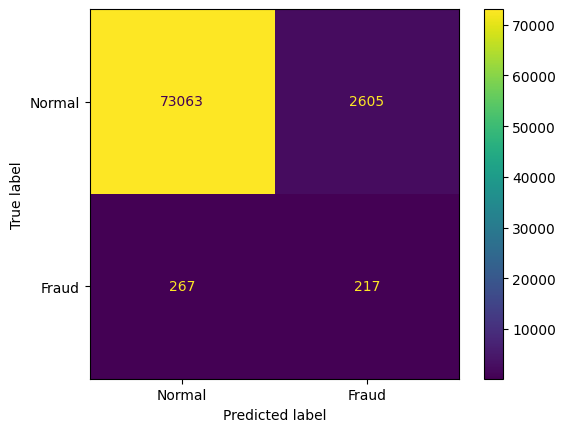

In [7]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Predict the test set
y_pred = best_model.predict(X_test_final)

# Print a classification report
print("Classification Report:")
print(classification_report(y_test_final, y_pred > 0.5))

# Create a confusion matrix
conf_matrix = confusion_matrix(y_test_final, y_pred > 0.5)
print("Confusion Matrix:")
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Normal', 'Fraud'])
disp.plot()
plt.show()


Epoch 1/15
5168/5168 [==============================] - 41s 7ms/step - loss: 0.0354 - accuracy: 0.9941 - precision: 0.9902 - recall: 0.9831 - auc: 0.9991 - val_loss: 0.0364 - val_accuracy: 0.9931 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5219
Epoch 2/15
5168/5168 [==============================] - 36s 7ms/step - loss: 0.0017 - accuracy: 0.9998 - precision: 1.0000 - recall: 0.9989 - auc: 0.9997 - val_loss: 0.0267 - val_accuracy: 0.9950 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6778
Epoch 3/15
5168/5168 [==============================] - 36s 7ms/step - loss: 0.0011 - accuracy: 0.9998 - precision: 1.0000 - recall: 0.9989 - auc: 0.9999 - val_loss: 0.0230 - val_accuracy: 0.9951 - val_precision: 0.0986 - val_recall: 0.0366 - val_auc: 0.7617
Epoch 4/15
5168/5168 [==============================] - 38s 7ms/step - loss: 7.6657e-04 - accuracy: 0.9998 - precision: 0.9999 - recall: 0.9991 - auc: 0.9999 - val_loss: 0.0234 - val_accuracy: 0.9955 - val_p

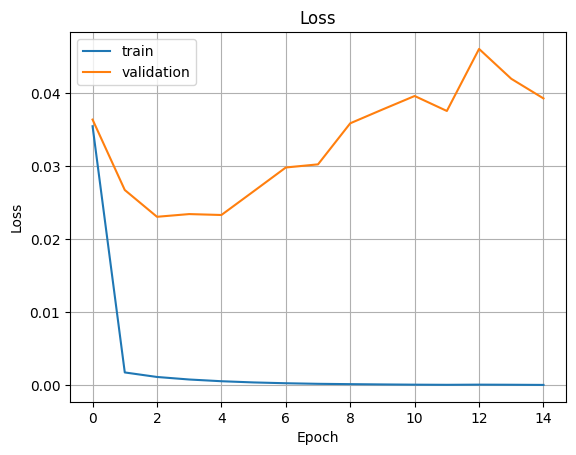

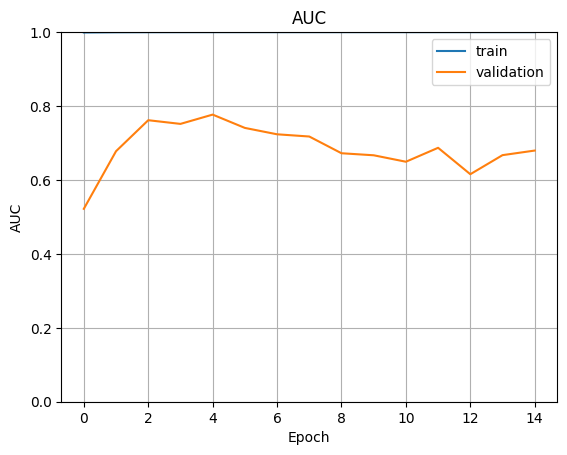

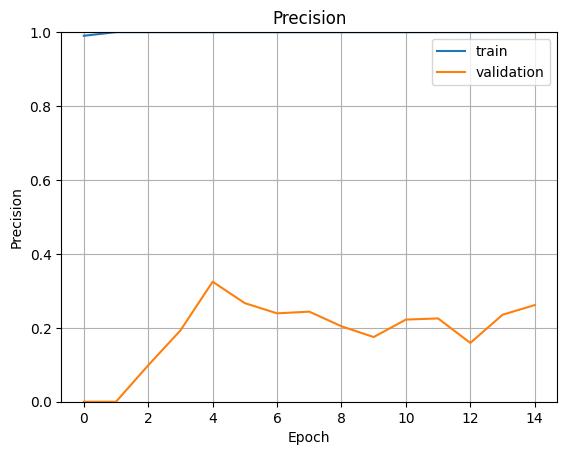

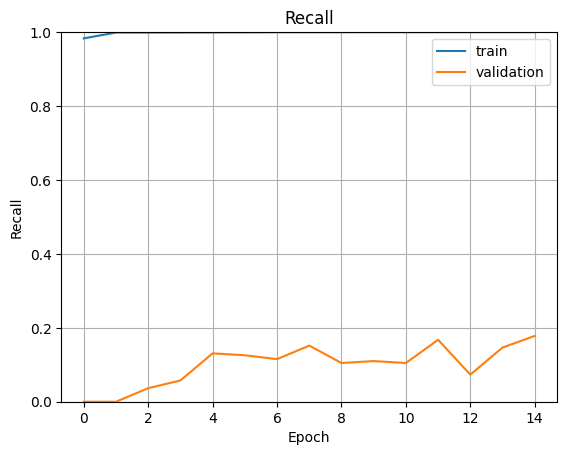

2380/2380 [==============================] - 9s 3ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     75668
           1       0.43      0.20      0.28       484

    accuracy                           0.99     76152
   macro avg       0.71      0.60      0.64     76152
weighted avg       0.99      0.99      0.99     76152

Confusion Matrix:


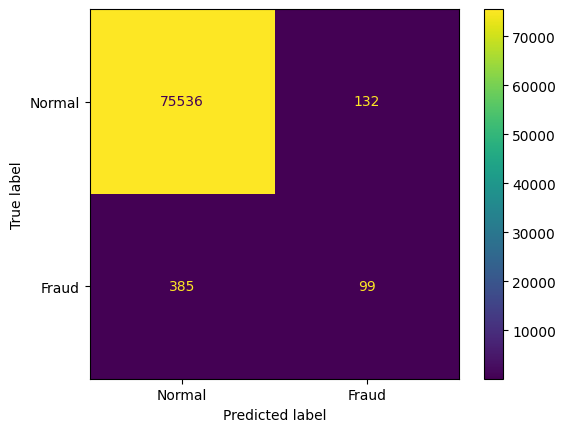

2380/2380 [==============================] - 7s 3ms/step


c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy

Epoch 1/15
5174/5174 [==============================] - 46s 8ms/step - loss: 0.0377 - accuracy: 0.9925 - precision: 0.9882 - recall: 0.9787 - auc: 0.9986 - val_loss: 0.0350 - val_accuracy: 0.9932 - val_precision: 0.0065 - val_recall: 0.0052 - val_auc: 0.5242
Epoch 2/15
5174/5174 [==============================] - 40s 8ms/step - loss: 0.0030 - accuracy: 0.9995 - precision: 0.9999 - recall: 0.9981 - auc: 0.9995 - val_loss: 0.0272 - val_accuracy: 0.9945 - val_precision: 0.0319 - val_recall: 0.0157 - val_auc: 0.7303
Epoch 3/15
5174/5174 [==============================] - 39s 8ms/step - loss: 0.0020 - accuracy: 0.9996 - precision: 0.9998 - recall: 0.9983 - auc: 0.9997 - val_loss: 0.0280 - val_accuracy: 0.9940 - val_precision: 0.1111 - val_recall: 0.0838 - val_auc: 0.7926
Epoch 4/15
5174/5174 [==============================] - 40s 8ms/step - loss: 0.0015 - accuracy: 0.9997 - precision: 0.9998 - recall: 0.9989 - auc: 0.9997 - val_loss: 0.0253 - val_accuracy: 0.9948 - val_precision: 0.1373 - v

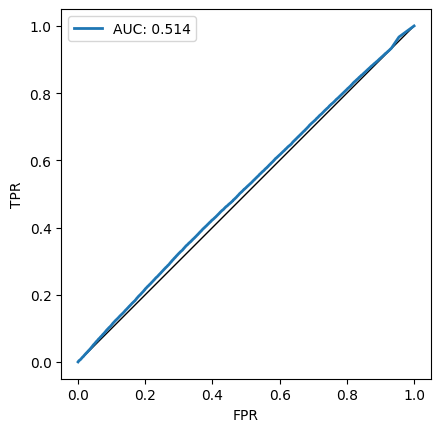

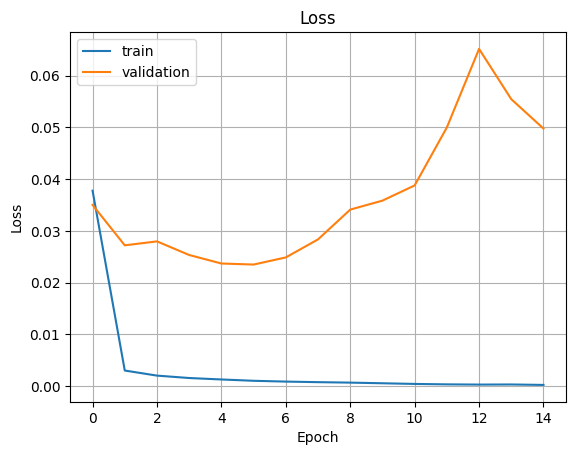

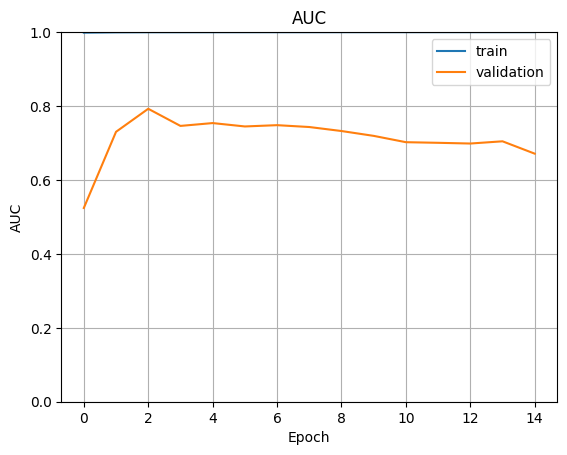

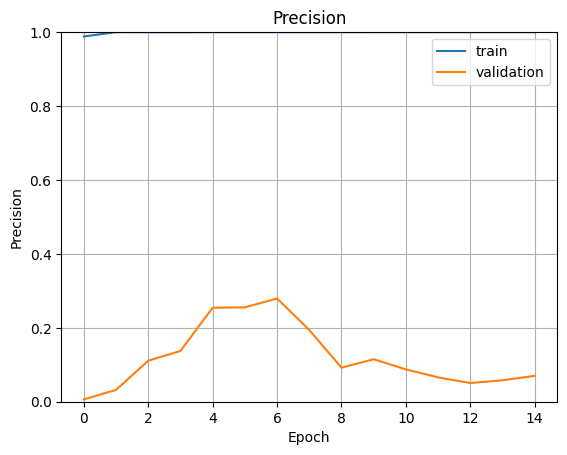

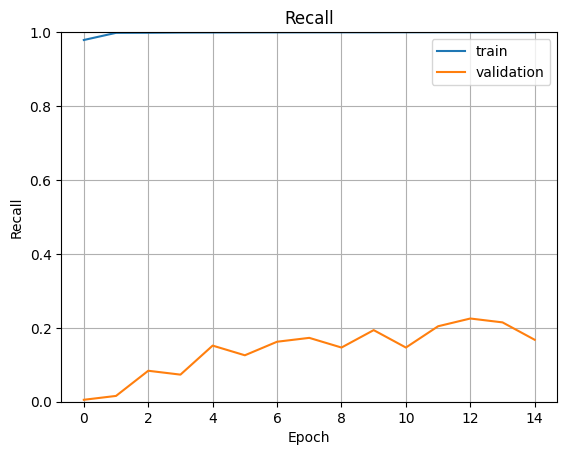

2380/2380 [==============================] - 8s 3ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     75668
           1       0.13      0.19      0.16       484

    accuracy                           0.99     76152
   macro avg       0.56      0.59      0.57     76152
weighted avg       0.99      0.99      0.99     76152

Confusion Matrix:


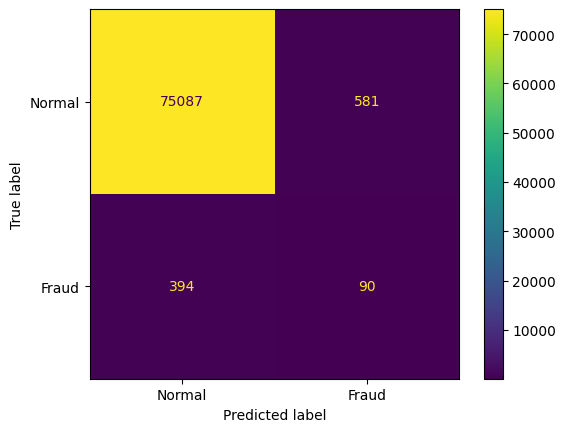

2380/2380 [==============================] - 7s 3ms/step


c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy

Epoch 1/15
5166/5166 [==============================] - 46s 8ms/step - loss: 0.0361 - accuracy: 0.9932 - precision: 0.9915 - recall: 0.9777 - auc: 0.9990 - val_loss: 0.0316 - val_accuracy: 0.9940 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6273
Epoch 2/15
5166/5166 [==============================] - 40s 8ms/step - loss: 0.0013 - accuracy: 0.9996 - precision: 0.9997 - recall: 0.9987 - auc: 0.9999 - val_loss: 0.0240 - val_accuracy: 0.9955 - val_precision: 0.0682 - val_recall: 0.0157 - val_auc: 0.7317
Epoch 3/15
5166/5166 [==============================] - 39s 8ms/step - loss: 8.2258e-04 - accuracy: 0.9997 - precision: 0.9996 - recall: 0.9990 - auc: 1.0000 - val_loss: 0.0228 - val_accuracy: 0.9958 - val_precision: 0.1471 - val_recall: 0.0262 - val_auc: 0.7486
Epoch 4/15
5166/5166 [==============================] - 40s 8ms/step - loss: 5.3731e-04 - accuracy: 0.9998 - precision: 0.9999 - recall: 0.9994 - auc: 1.0000 - val_loss: 0.0263 - val_accuracy: 0.9960 - val_preci

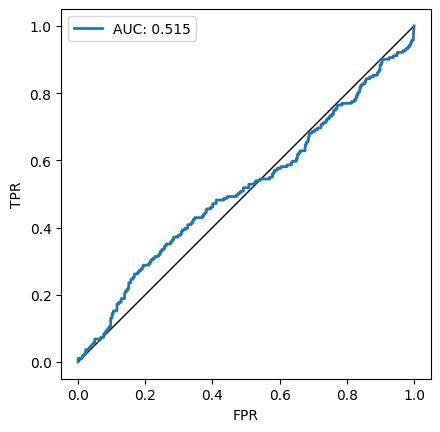

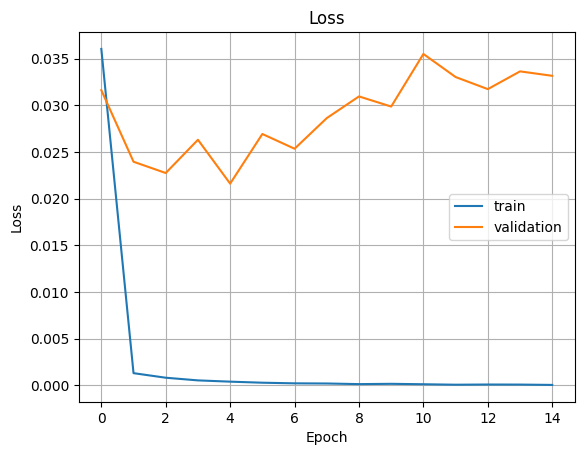

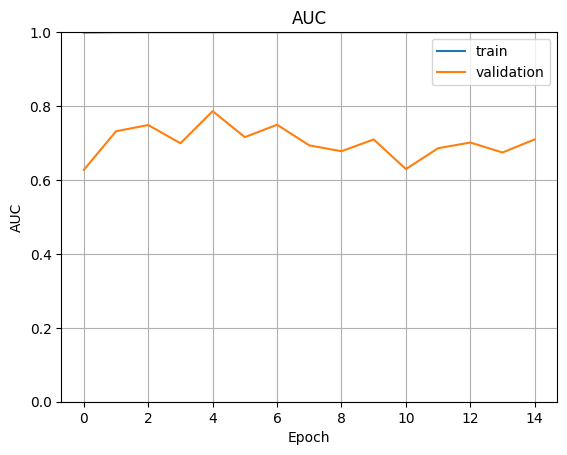

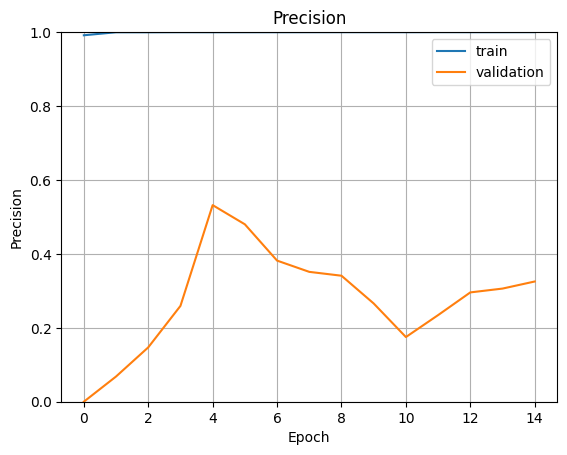

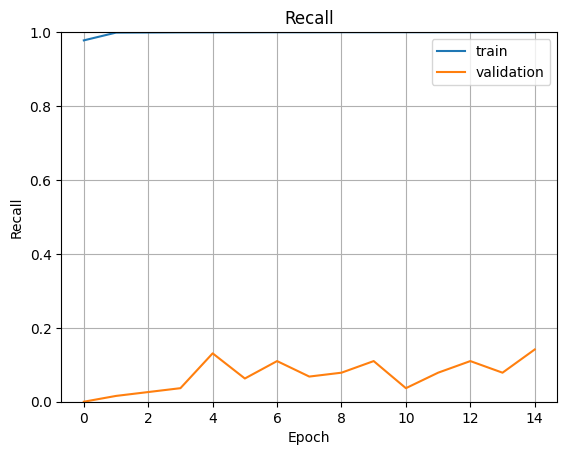

2380/2380 [==============================] - 8s 3ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     75668
           1       0.57      0.17      0.26       484

    accuracy                           0.99     76152
   macro avg       0.78      0.58      0.63     76152
weighted avg       0.99      0.99      0.99     76152

Confusion Matrix:


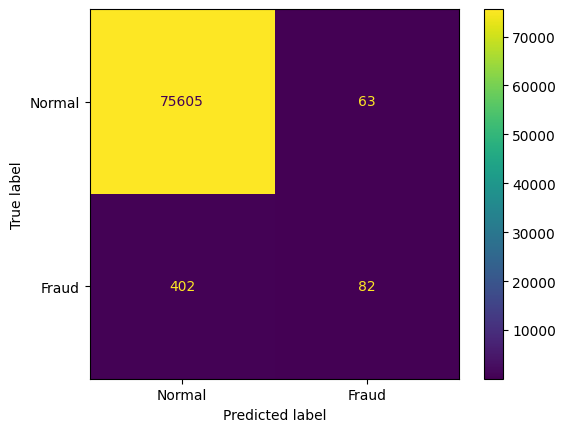

2380/2380 [==============================] - 7s 3ms/step


c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy

Epoch 1/15
5164/5164 [==============================] - 39s 7ms/step - loss: 0.0406 - accuracy: 0.9894 - precision: 0.9868 - recall: 0.9650 - auc: 0.9985 - val_loss: 0.0358 - val_accuracy: 0.9934 - val_precision: 0.0069 - val_recall: 0.0052 - val_auc: 0.5177
Epoch 2/15
5164/5164 [==============================] - 32s 6ms/step - loss: 0.0022 - accuracy: 0.9996 - precision: 0.9999 - recall: 0.9983 - auc: 0.9996 - val_loss: 0.0277 - val_accuracy: 0.9944 - val_precision: 0.0303 - val_recall: 0.0157 - val_auc: 0.7276
Epoch 3/15
5164/5164 [==============================] - 32s 6ms/step - loss: 0.0015 - accuracy: 0.9997 - precision: 0.9998 - recall: 0.9990 - auc: 0.9998 - val_loss: 0.0239 - val_accuracy: 0.9960 - val_precision: 0.1579 - val_recall: 0.0157 - val_auc: 0.7497
Epoch 4/15
5164/5164 [==============================] - 33s 6ms/step - loss: 0.0012 - accuracy: 0.9998 - precision: 0.9999 - recall: 0.9991 - auc: 0.9998 - val_loss: 0.0186 - val_accuracy: 0.9961 - val_precision: 0.4359 - v

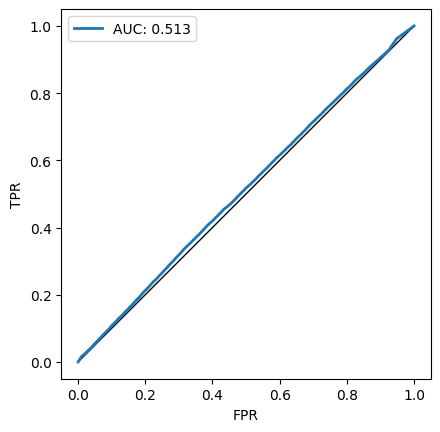

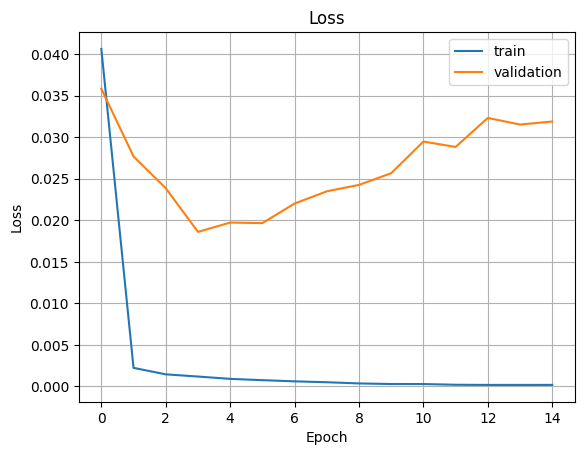

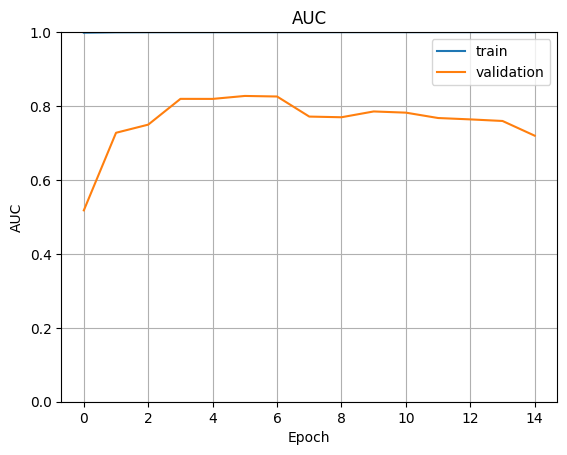

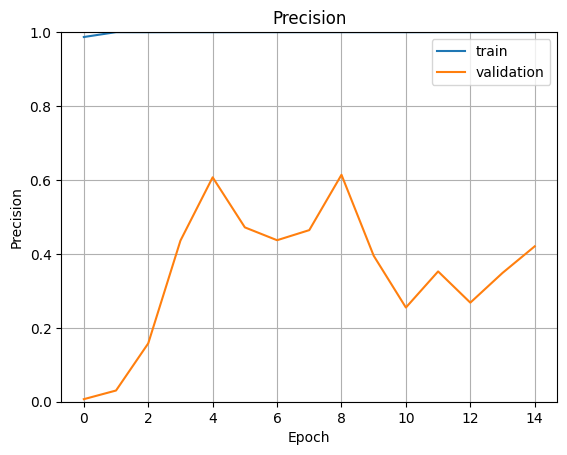

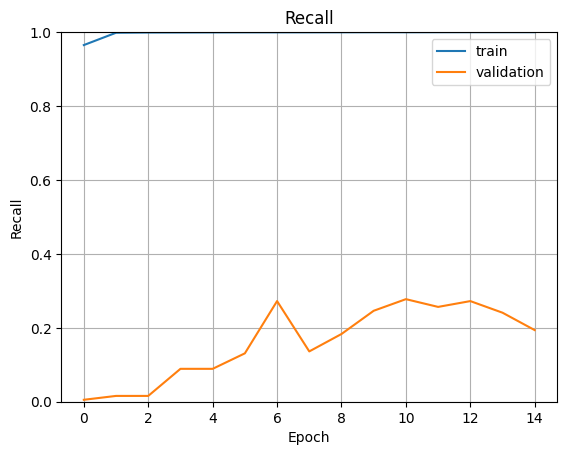

2380/2380 [==============================] - 10s 3ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     75668
           1       0.55      0.21      0.30       484

    accuracy                           0.99     76152
   macro avg       0.77      0.60      0.65     76152
weighted avg       0.99      0.99      0.99     76152

Confusion Matrix:


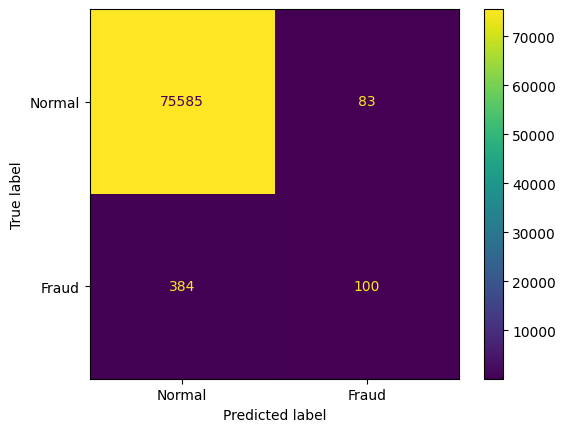

2380/2380 [==============================] - 11s 4ms/step


c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy

Epoch 1/15
5176/5176 [==============================] - 51s 9ms/step - loss: 0.0355 - accuracy: 0.9933 - precision: 0.9904 - recall: 0.9803 - auc: 0.9989 - val_loss: 0.0324 - val_accuracy: 0.9957 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5076
Epoch 2/15
5176/5176 [==============================] - 45s 9ms/step - loss: 0.0020 - accuracy: 0.9996 - precision: 0.9999 - recall: 0.9985 - auc: 0.9998 - val_loss: 0.0254 - val_accuracy: 0.9961 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6480
Epoch 3/15
5176/5176 [==============================] - 47s 9ms/step - loss: 0.0014 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9987 - auc: 0.9998 - val_loss: 0.0262 - val_accuracy: 0.9961 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6599
Epoch 4/15
5176/5176 [==============================] - 45s 9ms/step - loss: 0.0011 - accuracy: 0.9998 - precision: 0.9999 - recall: 0.9991 - auc: 0.9999 - val_loss: 0.0230 - val_accuracy: 0.9961 - v

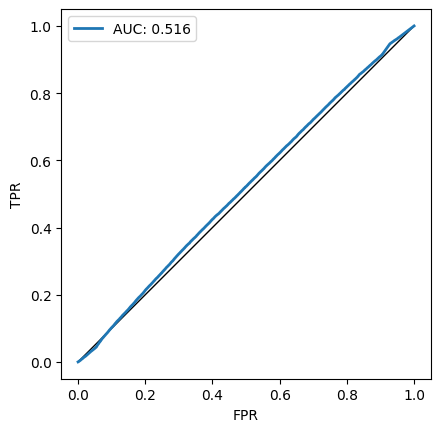

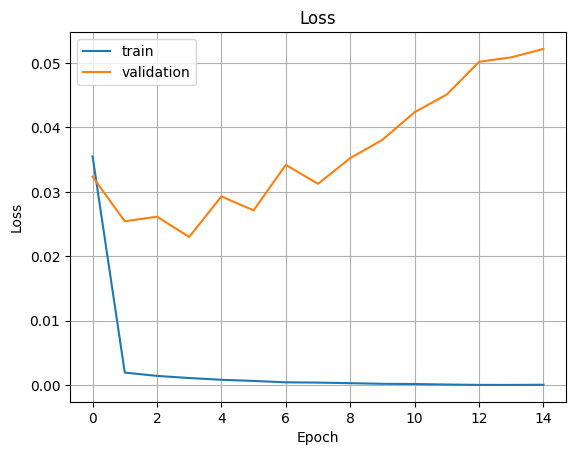

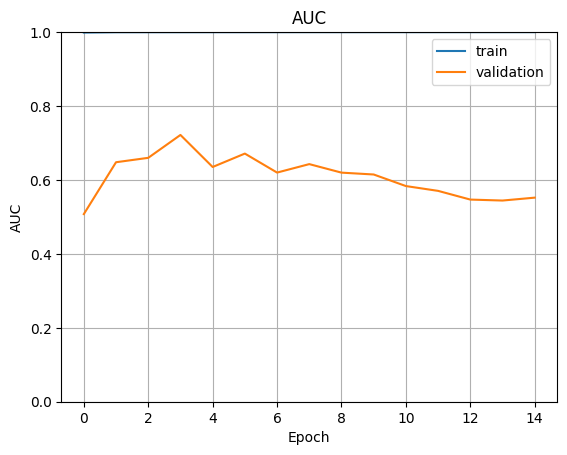

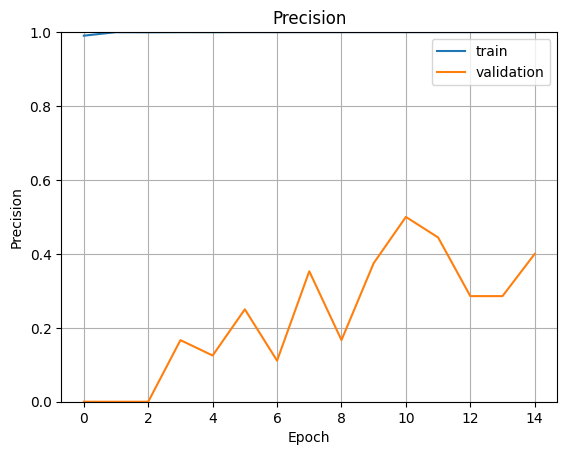

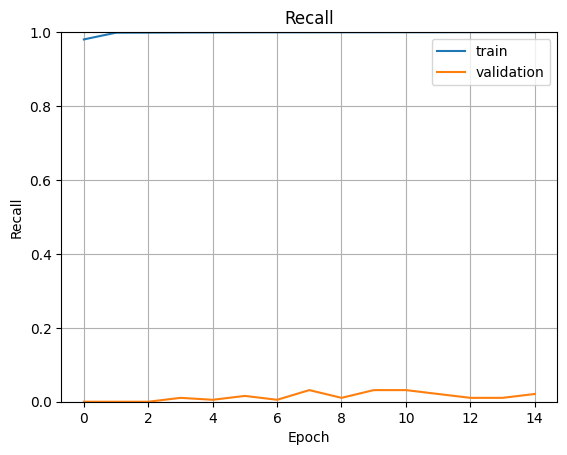

2380/2380 [==============================] - 15s 5ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     75668
           1       0.77      0.09      0.16       484

    accuracy                           0.99     76152
   macro avg       0.88      0.54      0.58     76152
weighted avg       0.99      0.99      0.99     76152

Confusion Matrix:


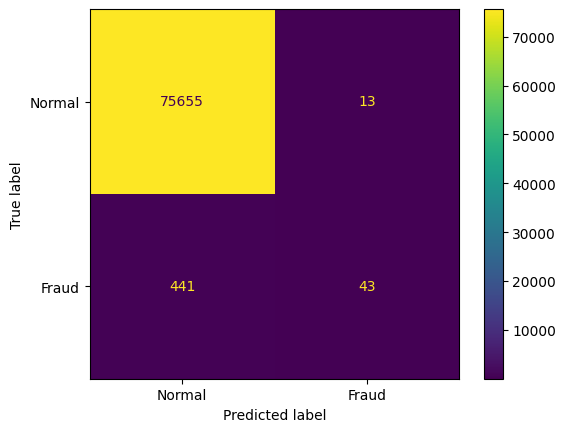

2380/2380 [==============================] - 11s 4ms/step


c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy

Epoch 1/15
5165/5165 [==============================] - 90s 16ms/step - loss: 0.0399 - accuracy: 0.9912 - precision: 0.9854 - recall: 0.9748 - auc: 0.9986 - val_loss: 0.0336 - val_accuracy: 0.9918 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6359
Epoch 2/15
5165/5165 [==============================] - 79s 15ms/step - loss: 0.0023 - accuracy: 0.9994 - precision: 0.9997 - recall: 0.9978 - auc: 0.9997 - val_loss: 0.0283 - val_accuracy: 0.9928 - val_precision: 0.0057 - val_recall: 0.0052 - val_auc: 0.7839
Epoch 3/15
5165/5165 [==============================] - 67s 13ms/step - loss: 0.0014 - accuracy: 0.9995 - precision: 0.9994 - recall: 0.9983 - auc: 0.9999 - val_loss: 0.0250 - val_accuracy: 0.9935 - val_precision: 0.0570 - val_recall: 0.0471 - val_auc: 0.8241
Epoch 4/15
5165/5165 [==============================] - 68s 13ms/step - loss: 9.7559e-04 - accuracy: 0.9996 - precision: 0.9993 - recall: 0.9990 - auc: 1.0000 - val_loss: 0.0288 - val_accuracy: 0.9942 - val_preci

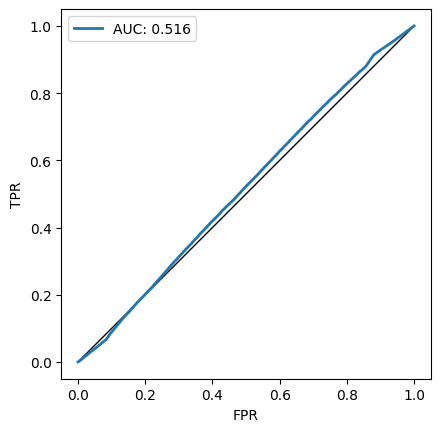

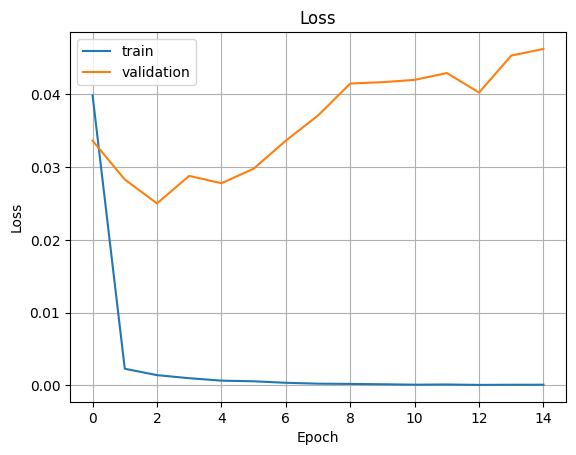

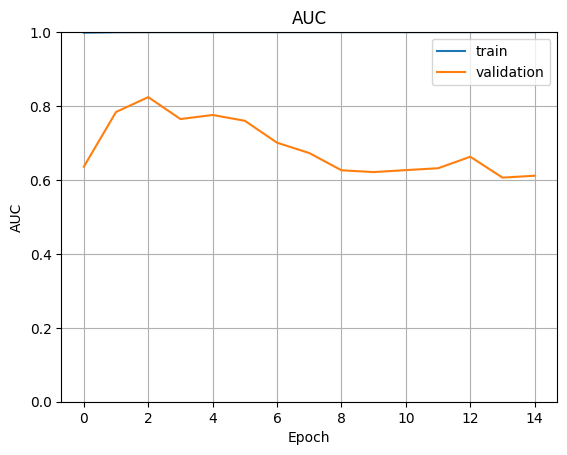

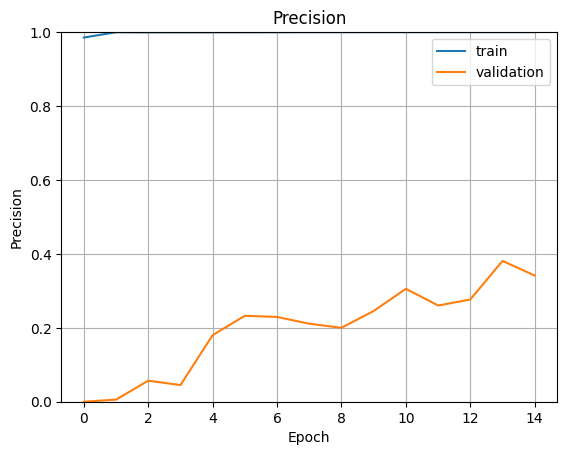

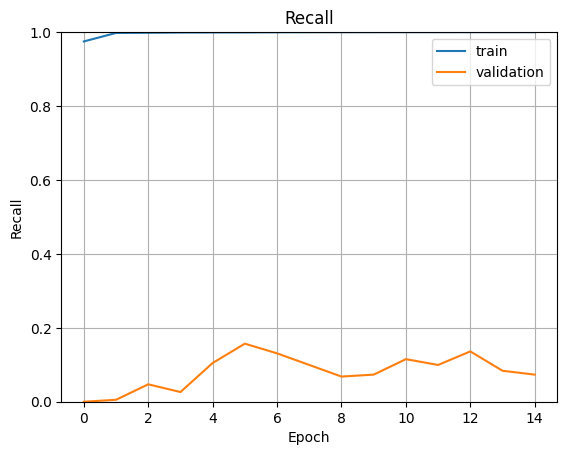

2380/2380 [==============================] - 15s 5ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     75668
           1       0.92      0.19      0.31       484

    accuracy                           0.99     76152
   macro avg       0.96      0.59      0.65     76152
weighted avg       0.99      0.99      0.99     76152

Confusion Matrix:


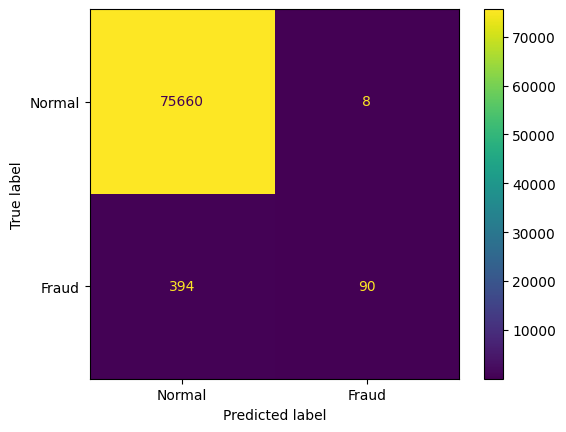

2380/2380 [==============================] - 12s 5ms/step


c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy

Epoch 1/15
5170/5170 [==============================] - 87s 15ms/step - loss: 0.0384 - accuracy: 0.9927 - precision: 0.9904 - recall: 0.9770 - auc: 0.9988 - val_loss: 0.0325 - val_accuracy: 0.9947 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4900
Epoch 2/15
5170/5170 [==============================] - 71s 14ms/step - loss: 0.0020 - accuracy: 0.9997 - precision: 0.9999 - recall: 0.9985 - auc: 0.9997 - val_loss: 0.0272 - val_accuracy: 0.9956 - val_precision: 0.0312 - val_recall: 0.0052 - val_auc: 0.6425
Epoch 3/15
5170/5170 [==============================] - 73s 14ms/step - loss: 9.7618e-04 - accuracy: 0.9997 - precision: 0.9998 - recall: 0.9987 - auc: 1.0000 - val_loss: 0.0251 - val_accuracy: 0.9957 - val_precision: 0.2000 - val_recall: 0.0471 - val_auc: 0.7210
Epoch 4/15
5170/5170 [==============================] - 78s 15ms/step - loss: 6.2082e-04 - accuracy: 0.9998 - precision: 0.9997 - recall: 0.9992 - auc: 1.0000 - val_loss: 0.0242 - val_accuracy: 0.9955 - val_p

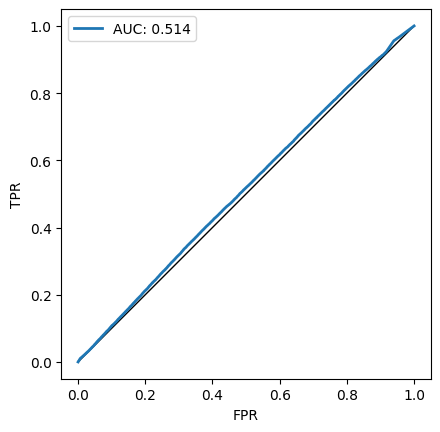

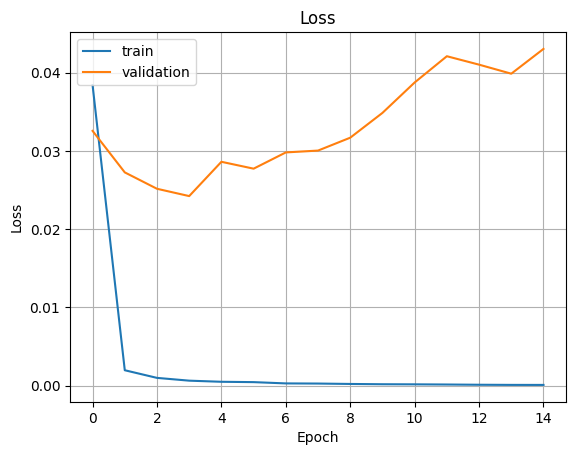

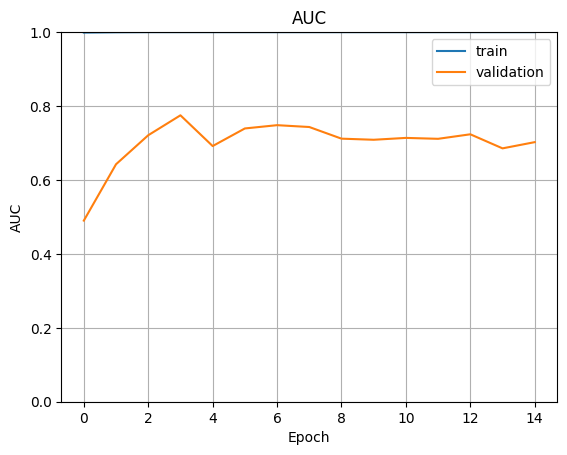

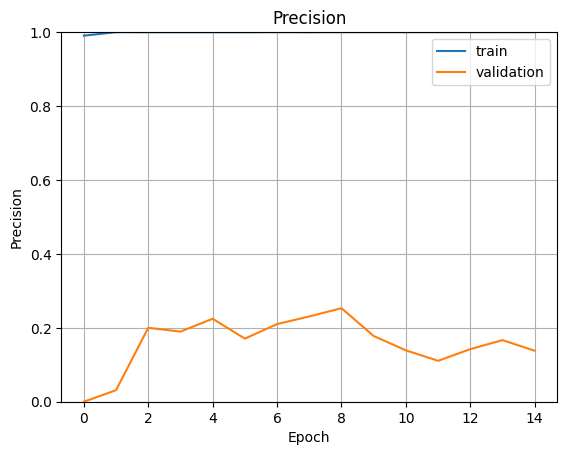

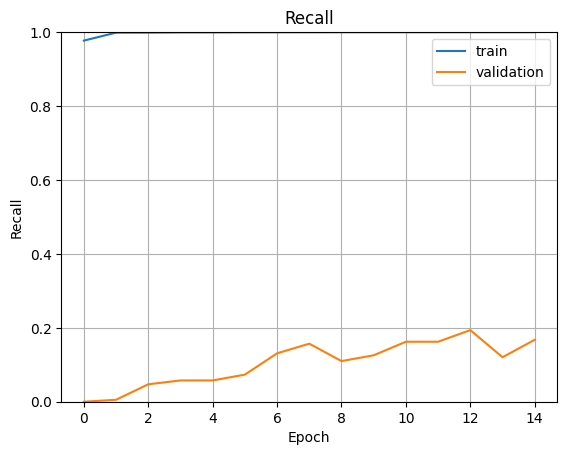

2380/2380 [==============================] - 21s 8ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     75668
           1       0.25      0.20      0.22       484

    accuracy                           0.99     76152
   macro avg       0.62      0.60      0.61     76152
weighted avg       0.99      0.99      0.99     76152

Confusion Matrix:


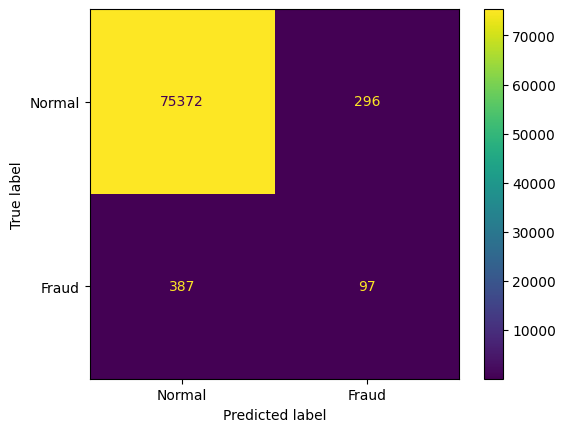

2380/2380 [==============================] - 18s 7ms/step


c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy

Epoch 1/15
5166/5166 [==============================] - 113s 19ms/step - loss: 0.0393 - accuracy: 0.9918 - precision: 0.9905 - recall: 0.9725 - auc: 0.9985 - val_loss: 0.0390 - val_accuracy: 0.9917 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5534
Epoch 2/15
5166/5166 [==============================] - 98s 19ms/step - loss: 0.0022 - accuracy: 0.9994 - precision: 0.9998 - recall: 0.9977 - auc: 0.9998 - val_loss: 0.0326 - val_accuracy: 0.9921 - val_precision: 0.0314 - val_recall: 0.0366 - val_auc: 0.7969
Epoch 3/15
5166/5166 [==============================] - 89s 17ms/step - loss: 0.0014 - accuracy: 0.9995 - precision: 0.9994 - recall: 0.9984 - auc: 0.9999 - val_loss: 0.0252 - val_accuracy: 0.9944 - val_precision: 0.1034 - val_recall: 0.0628 - val_auc: 0.8176
Epoch 4/15
5166/5166 [==============================] - 89s 17ms/step - loss: 0.0011 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9989 - auc: 0.9999 - val_loss: 0.0251 - val_accuracy: 0.9943 - val_precisio

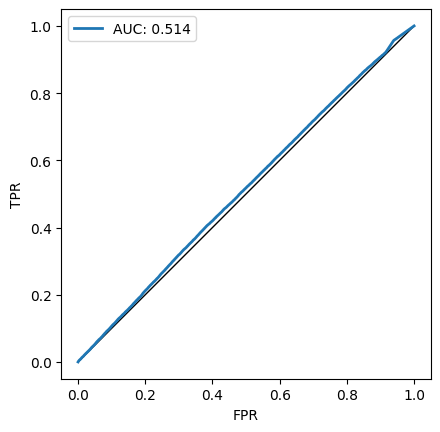

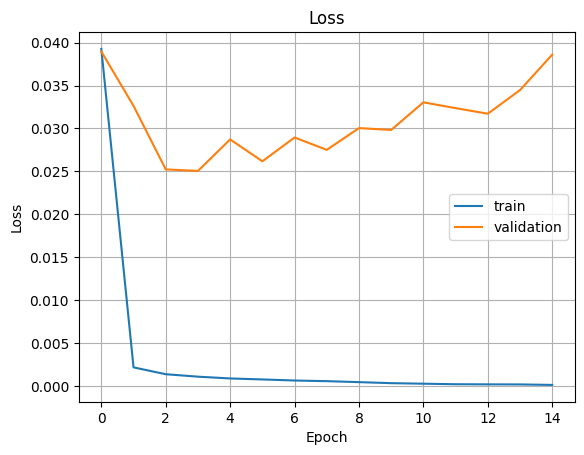

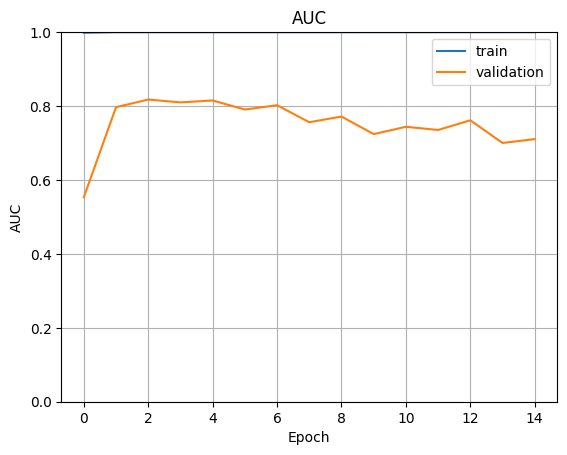

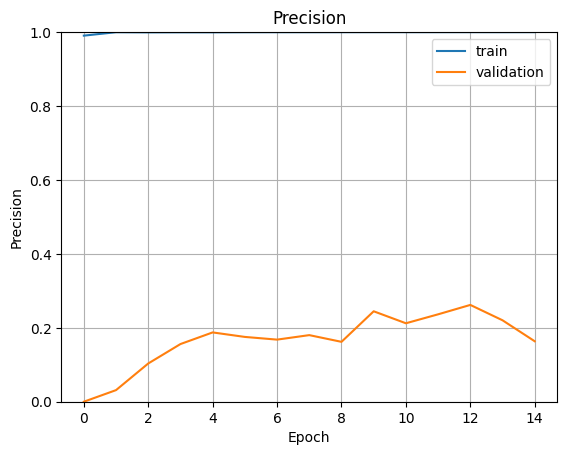

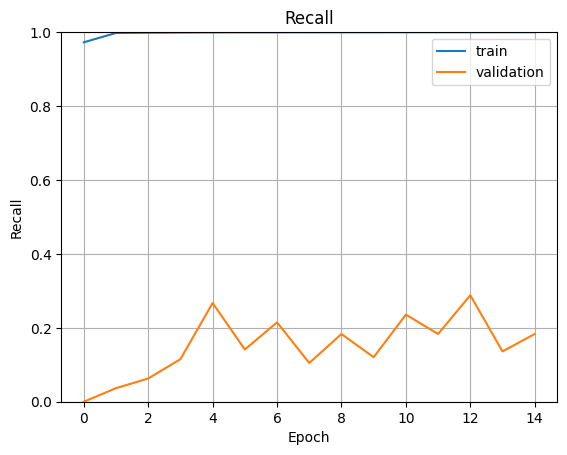

2380/2380 [==============================] - 18s 6ms/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     75668
           1       0.34      0.27      0.30       484

    accuracy                           0.99     76152
   macro avg       0.67      0.63      0.65     76152
weighted avg       0.99      0.99      0.99     76152

Confusion Matrix:


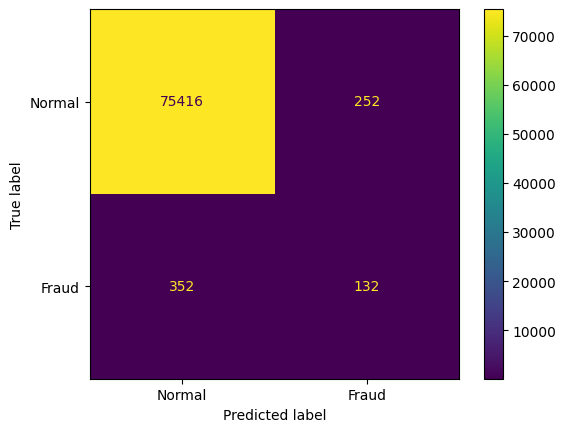

2380/2380 [==============================] - 14s 6ms/step


c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy

Epoch 1/15
5170/5170 [==============================] - 80s 13ms/step - loss: 0.0378 - accuracy: 0.9933 - precision: 0.9911 - recall: 0.9791 - auc: 0.9987 - val_loss: 0.0518 - val_accuracy: 0.9855 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5348
Epoch 2/15
5170/5170 [==============================] - 79s 15ms/step - loss: 0.0026 - accuracy: 0.9995 - precision: 0.9998 - recall: 0.9979 - auc: 0.9996 - val_loss: 0.0370 - val_accuracy: 0.9911 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6913
Epoch 3/15
5170/5170 [==============================] - 83s 16ms/step - loss: 0.0019 - accuracy: 0.9995 - precision: 0.9995 - recall: 0.9981 - auc: 0.9999 - val_loss: 0.0394 - val_accuracy: 0.9893 - val_precision: 0.0111 - val_recall: 0.0209 - val_auc: 0.7317
Epoch 4/15
5170/5170 [==============================] - 84s 16ms/step - loss: 0.0014 - accuracy: 0.9996 - precision: 0.9996 - recall: 0.9985 - auc: 0.9999 - val_loss: 0.0389 - val_accuracy: 0.9891 - val_p

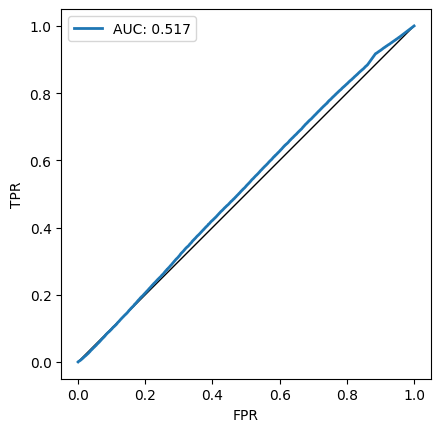

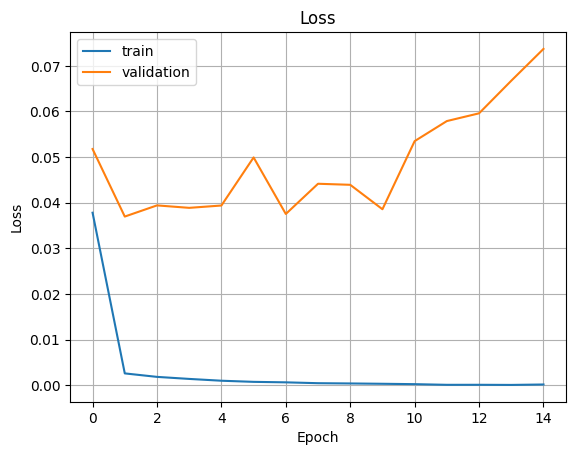

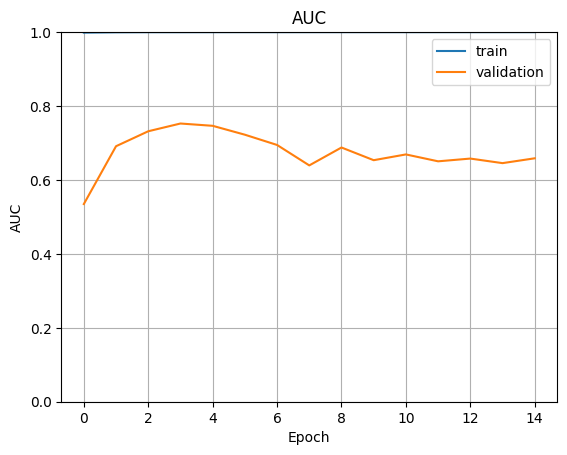

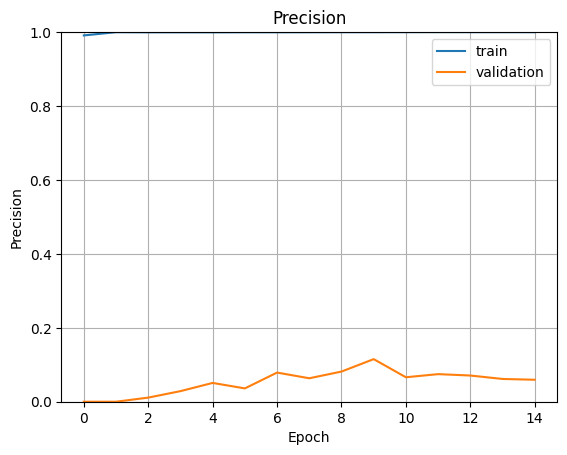

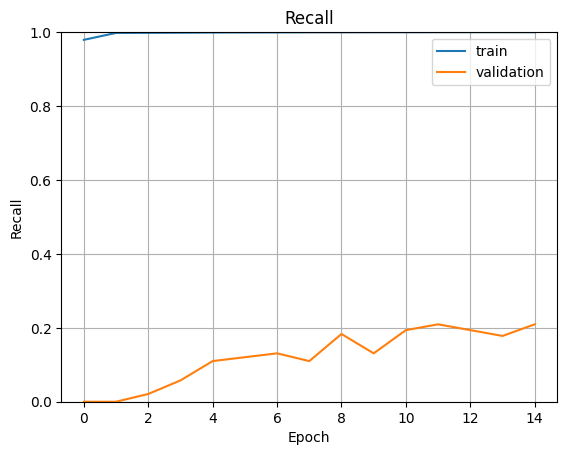

2380/2380 [==============================] - 16s 6ms/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     75668
           1       0.11      0.25      0.15       484

    accuracy                           0.98     76152
   macro avg       0.55      0.62      0.57     76152
weighted avg       0.99      0.98      0.99     76152

Confusion Matrix:


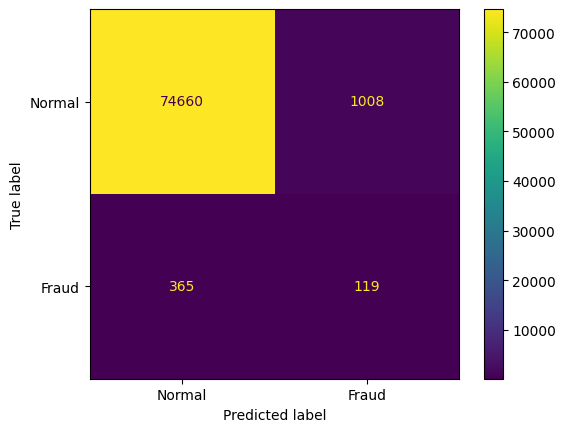

2380/2380 [==============================] - 14s 6ms/step


c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy

Epoch 1/15
5171/5171 [==============================] - 90s 15ms/step - loss: 0.0377 - accuracy: 0.9931 - precision: 0.9926 - recall: 0.9769 - auc: 0.9988 - val_loss: 0.0366 - val_accuracy: 0.9931 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5251
Epoch 2/15
5171/5171 [==============================] - 79s 15ms/step - loss: 0.0023 - accuracy: 0.9995 - precision: 0.9999 - recall: 0.9980 - auc: 0.9997 - val_loss: 0.0322 - val_accuracy: 0.9936 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6688
Epoch 3/15
5171/5171 [==============================] - 64s 12ms/step - loss: 0.0014 - accuracy: 0.9996 - precision: 0.9997 - recall: 0.9986 - auc: 0.9999 - val_loss: 0.0305 - val_accuracy: 0.9936 - val_precision: 0.0350 - val_recall: 0.0262 - val_auc: 0.6960
Epoch 4/15
5171/5171 [==============================] - 47s 9ms/step - loss: 0.0011 - accuracy: 0.9997 - precision: 0.9997 - recall: 0.9991 - auc: 0.9999 - val_loss: 0.0294 - val_accuracy: 0.9943 - val_pr

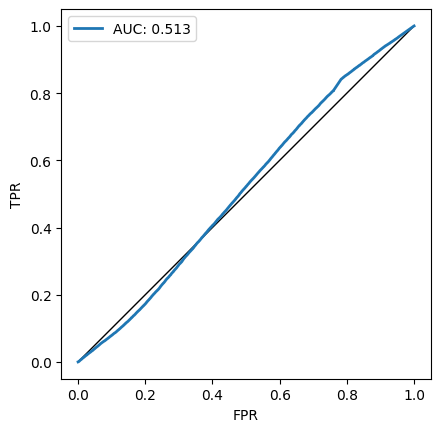

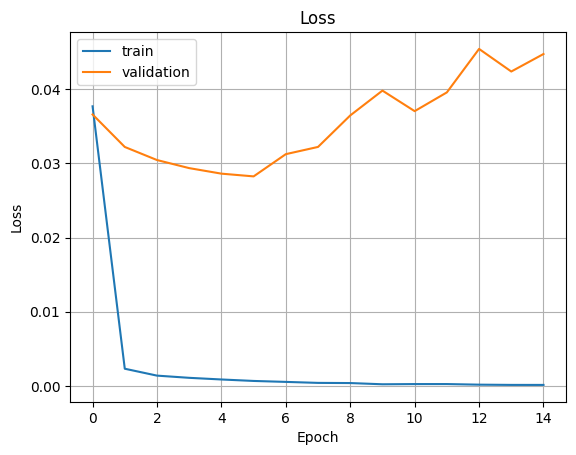

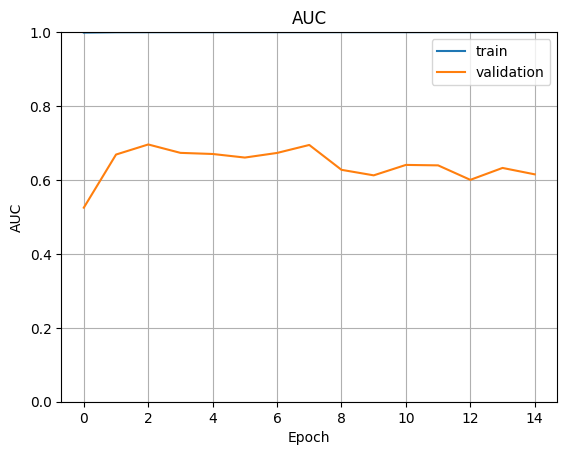

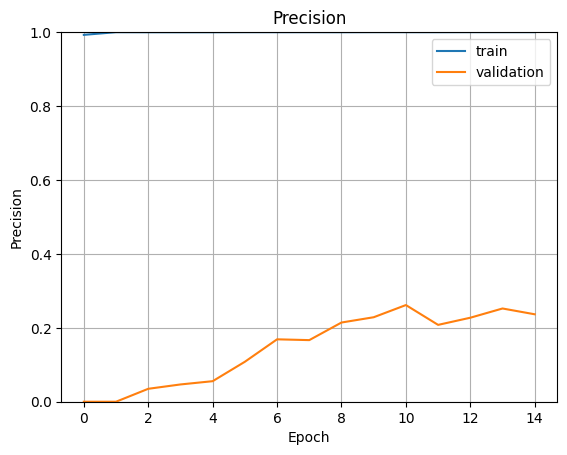

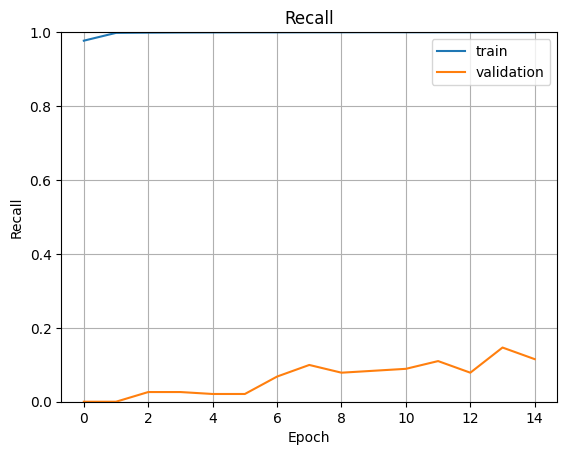

2380/2380 [==============================] - 13s 4ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     75668
           1       0.54      0.16      0.25       484

    accuracy                           0.99     76152
   macro avg       0.77      0.58      0.62     76152
weighted avg       0.99      0.99      0.99     76152

Confusion Matrix:


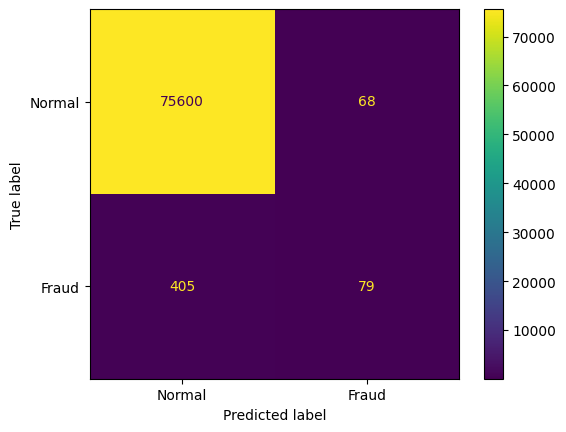

2380/2380 [==============================] - 9s 4ms/step


c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy

Epoch 1/15
5172/5172 [==============================] - 55s 9ms/step - loss: 0.0386 - accuracy: 0.9905 - precision: 0.9905 - recall: 0.9677 - auc: 0.9987 - val_loss: 0.0321 - val_accuracy: 0.9950 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5396
Epoch 2/15
5172/5172 [==============================] - 48s 9ms/step - loss: 0.0021 - accuracy: 0.9997 - precision: 1.0000 - recall: 0.9985 - auc: 0.9997 - val_loss: 0.0285 - val_accuracy: 0.9956 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6013
Epoch 3/15
5172/5172 [==============================] - 47s 9ms/step - loss: 0.0014 - accuracy: 0.9997 - precision: 0.9999 - recall: 0.9987 - auc: 0.9998 - val_loss: 0.0261 - val_accuracy: 0.9959 - val_precision: 0.1053 - val_recall: 0.0105 - val_auc: 0.6711
Epoch 4/15
5172/5172 [==============================] - 48s 9ms/step - loss: 0.0010 - accuracy: 0.9998 - precision: 0.9999 - recall: 0.9991 - auc: 0.9999 - val_loss: 0.0316 - val_accuracy: 0.9960 - val_preci

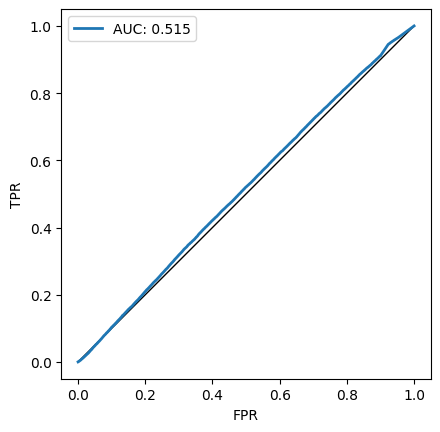

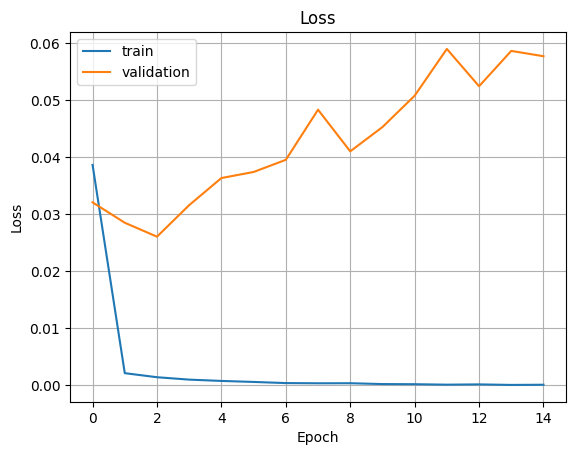

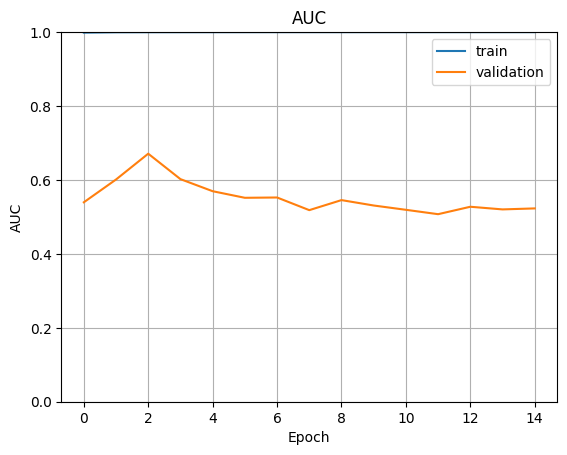

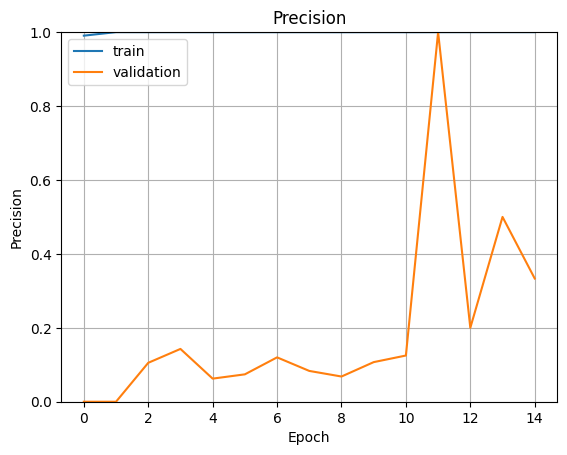

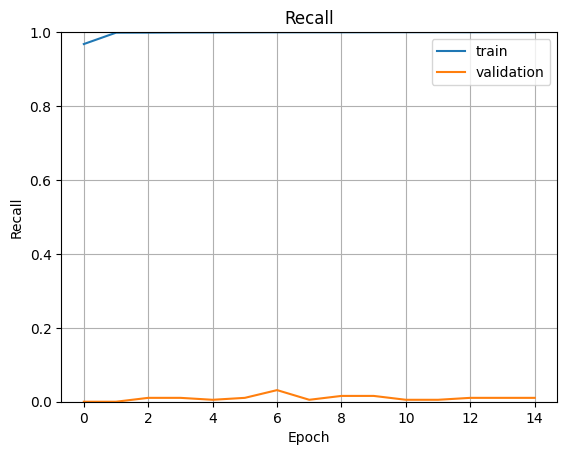

2380/2380 [==============================] - 10s 3ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     75668
           1       0.29      0.00      0.01       484

    accuracy                           0.99     76152
   macro avg       0.64      0.50      0.50     76152
weighted avg       0.99      0.99      0.99     76152

Confusion Matrix:


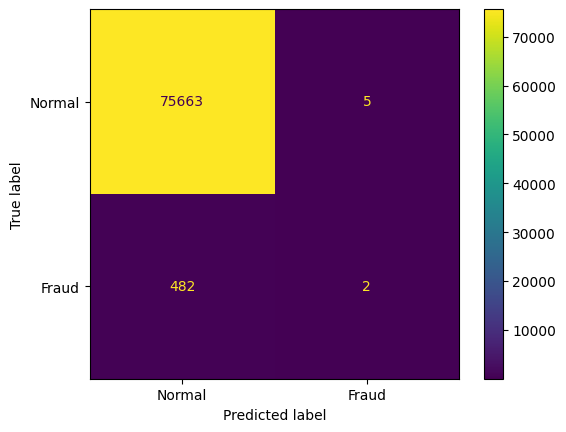

2380/2380 [==============================] - 8s 3ms/step


c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy

Epoch 1/15
5167/5167 [==============================] - 55s 9ms/step - loss: 0.0371 - accuracy: 0.9933 - precision: 0.9924 - recall: 0.9775 - auc: 0.9988 - val_loss: 0.0328 - val_accuracy: 0.9938 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5422
Epoch 2/15
5167/5167 [==============================] - 46s 9ms/step - loss: 0.0022 - accuracy: 0.9996 - precision: 0.9999 - recall: 0.9984 - auc: 0.9996 - val_loss: 0.0269 - val_accuracy: 0.9955 - val_precision: 0.0238 - val_recall: 0.0052 - val_auc: 0.6831
Epoch 3/15
5167/5167 [==============================] - 46s 9ms/step - loss: 0.0015 - accuracy: 0.9996 - precision: 0.9997 - recall: 0.9986 - auc: 0.9998 - val_loss: 0.0245 - val_accuracy: 0.9957 - val_precision: 0.0370 - val_recall: 0.0052 - val_auc: 0.7202
Epoch 4/15
5167/5167 [==============================] - 47s 9ms/step - loss: 0.0011 - accuracy: 0.9997 - precision: 0.9997 - recall: 0.9988 - auc: 0.9999 - val_loss: 0.0256 - val_accuracy: 0.9962 - val_precision: 0.

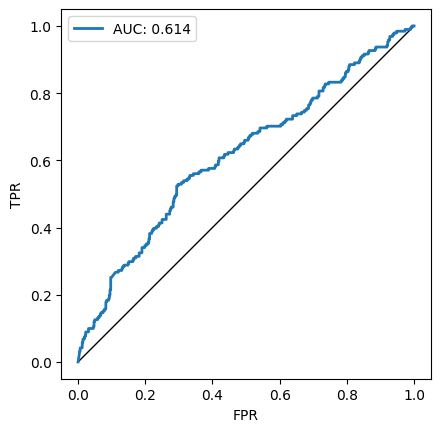

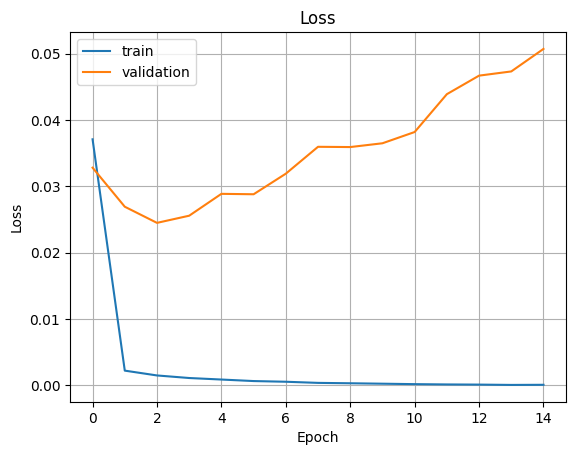

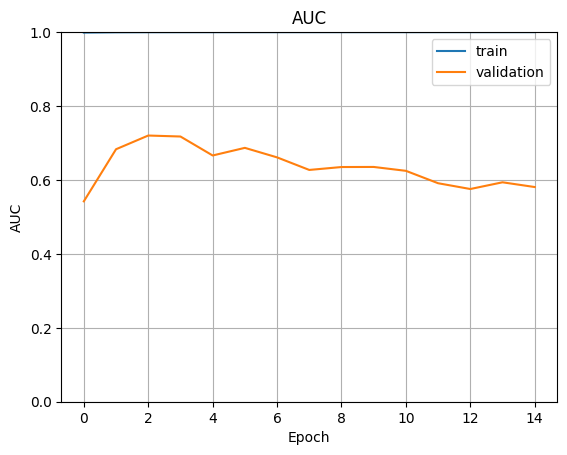

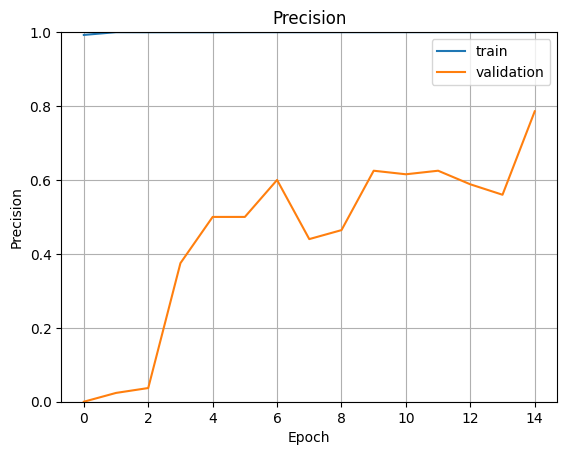

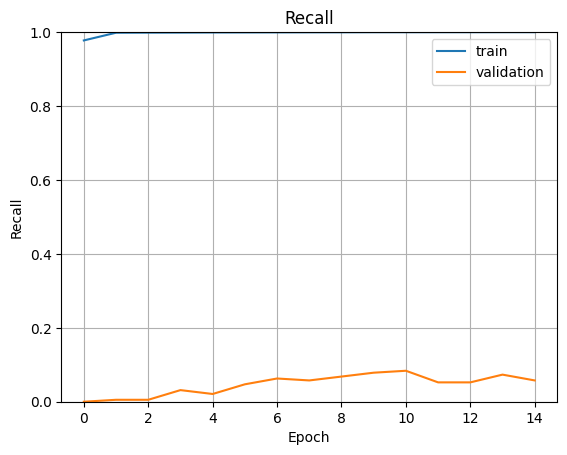

2380/2380 [==============================] - 10s 3ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     75668
           1       0.63      0.05      0.09       484

    accuracy                           0.99     76152
   macro avg       0.81      0.52      0.54     76152
weighted avg       0.99      0.99      0.99     76152

Confusion Matrix:


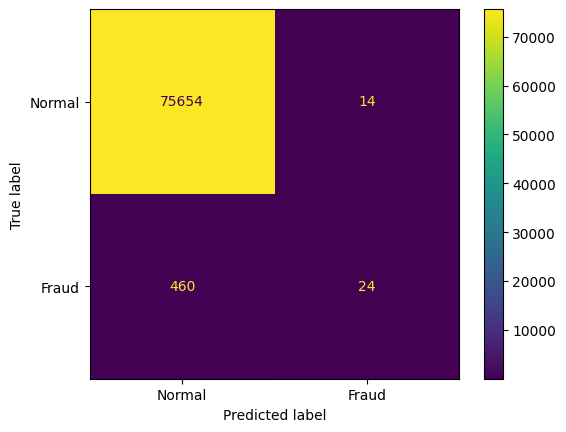

2380/2380 [==============================] - 8s 3ms/step


c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy

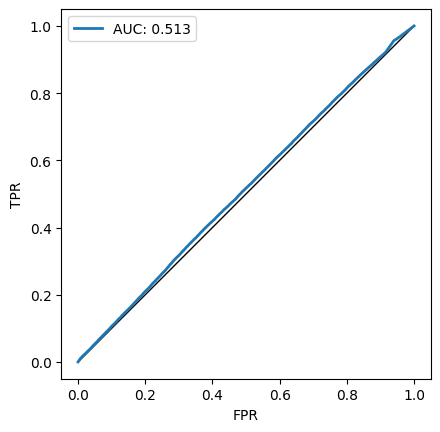

In [18]:
from services.modeling import train_and_plot_results
from services.eval_privacy import compute_mia_attacks



epsilon_values = [0.1, 1, 10]
delta_values = [1e-6, 1e-8, 1e-10, 1e-12]

models = {}
hists = {}
attack_results = {}

for eps in epsilon_values:
    if eps not in models:
        models[eps] = {}
        hists[eps] = {}
        attack_results[eps] = {}
    for delta in delta_values:
        Xt = X_train_seq_proc_smote[eps][delta]
        yt = y_train_seq_proc_smote[eps][delta]
        Xv = X_val_seq_proc[eps][delta]
        yv = y_val_seq_proc[eps][delta]
        Xte = X_test_seq_proc[eps][delta]
        yte = y_test_seq_proc[eps][delta]
        model, hist = train_and_plot_results(Xt, yt, Xte, yte, best_hp, X_val=Xv, y_val=yv)

        nrows = len(X_test_final)
        attack_result, fig = compute_mia_attacks(best_model, X_val_seq[:nrows], X_test_final[:nrows], y_val_seq[:nrows], y_test_final[:nrows])

        models[eps][delta] = model
        hists[eps][delta] = hist
        attack_results[eps][delta] = attack_result


In [19]:
for eps in epsilon_values:
    for delta in delta_values:
        model = models[eps][delta]
        model.save(f'model/dp_oversampled_dataset/lstm_oversampled_eps_{eps}_delta_{delta}.keras')

In [ ]:
from keras.models import load_model

models = {}

for eps in epsilon_values:
    if eps not in models:
        models[eps] = {}
    for delta in delta_values:
        model = load_model(f'model/dp_oversampled_dataset/lstm_oversampled_eps_{eps}_delta_{delta}.keras')
        models[eps][delta] = model

2380/2380 [==============================] - 6s 3ms/step


c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy

2380/2380 [==============================] - 9s 4ms/step


c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy

2380/2380 [==============================] - 6s 2ms/step


c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy

2380/2380 [==============================] - 6s 3ms/step


c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy

2380/2380 [==============================] - 6s 3ms/step


c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy

2380/2380 [==============================] - 7s 3ms/step


c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy

2380/2380 [==============================] - 7s 3ms/step


c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy

2380/2380 [==============================] - 7s 3ms/step


c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy

   1/1587 [..............................] - ETA: 1:08

c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


2380/2380 [==============================] - 7s 3ms/step


c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy

  18/1587 [..............................] - ETA: 4s  

c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


2380/2380 [==============================] - 6s 3ms/step


c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy

   1/1587 [..............................] - ETA: 1:31

c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


2380/2380 [==============================] - 7s 3ms/step


c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy

  18/1587 [..............................] - ETA: 4s  

c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -


2380/2380 [==============================] - 6s 3ms/step


c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:335: RuntimeWarning: divide by zero encountered in divide
  (self._z**2 * fnr * tnr) /
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: invalid value encountered in subtract
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy\tensorflow_privacy\privacy\privacy_tests\epsilon_lower_bound.py:334: RuntimeWarning: divide by zero encountered in divide
  power_3_term_numer = 1 + self._z / 3 * np.sqrt(fnr / tp + tnr / fp -
c:\users\albert salles\documents\personal\mtu\privacy

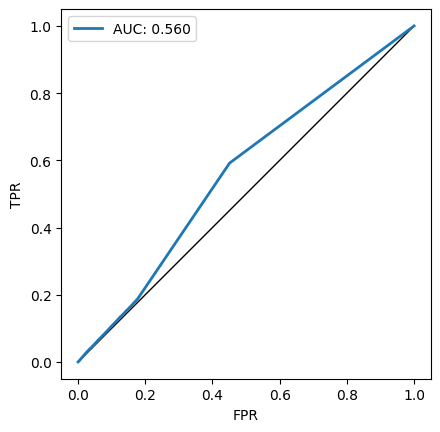

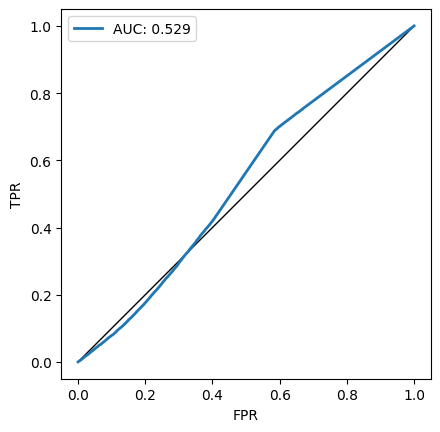

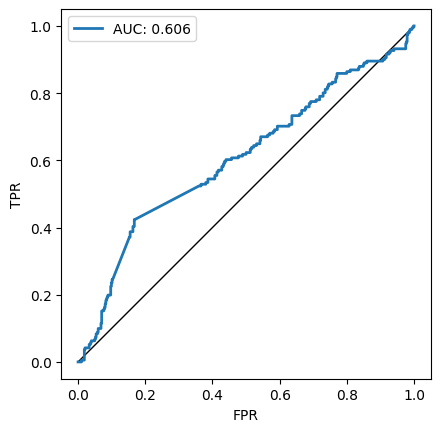

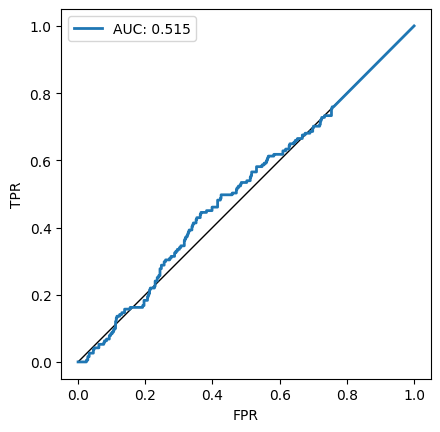

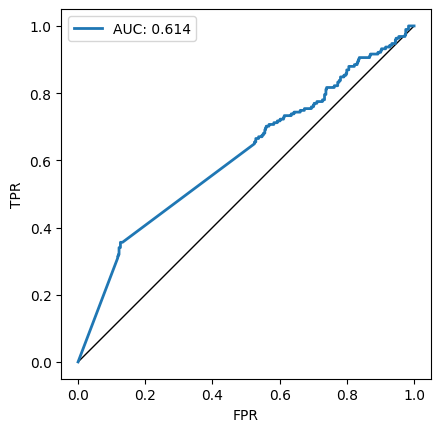

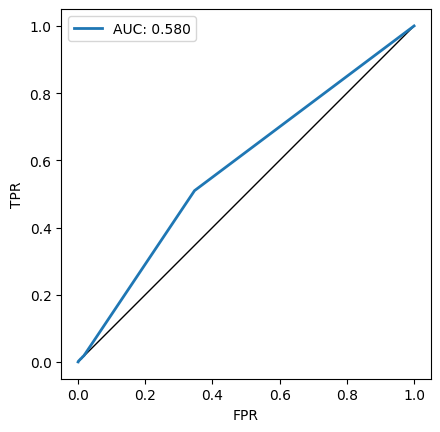

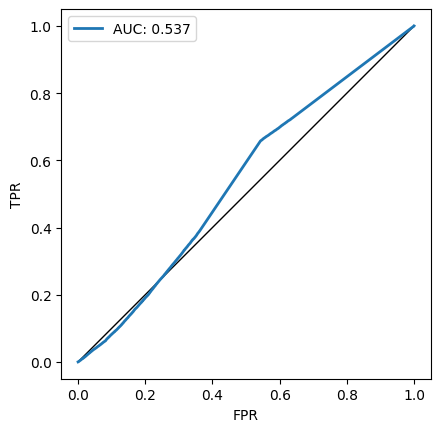

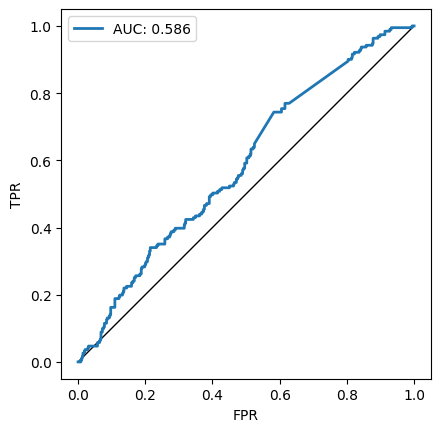

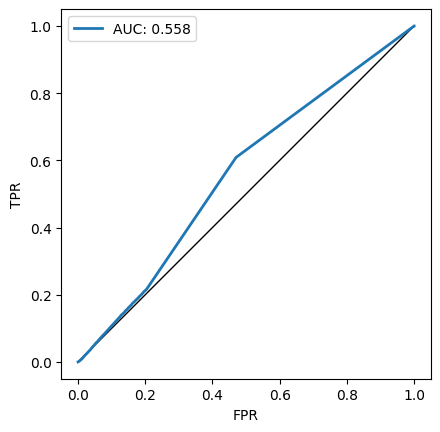

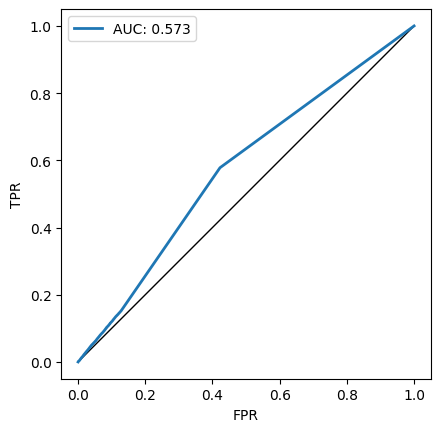

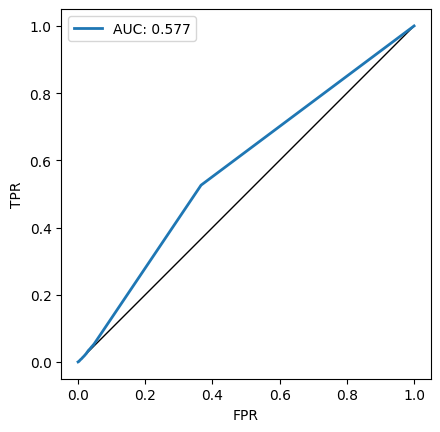

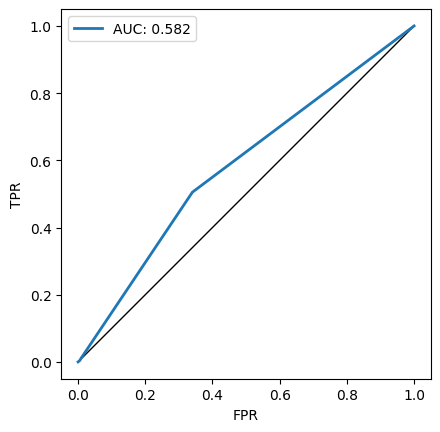

In [24]:
for eps in epsilon_values:
    for delta in delta_values:
        model = models[eps][delta]
        
        Xt = X_train_seq_proc_smote[eps][delta]
        yt = y_train_seq_proc_smote[eps][delta]
        Xv = X_val_seq_proc[eps][delta]
        yv = y_val_seq_proc[eps][delta]
        Xte = X_test_seq_proc[eps][delta]
        yte = y_test_seq_proc[eps][delta]

        n_rows = len(Xte)
        attacks_result, figure = compute_mia_attacks(model, Xt[:n_rows], Xte[:n_rows], yt[:n_rows], yte[:n_rows])

        attack_results[eps][delta] = attacks_result.get_result_with_max_auc()

In [25]:
import pickle

with open('results/dp_lstm/dp_results_per_eps_delta_dp_oversampling.pkl', 'wb') as f: 
    pickle.dump(attack_results, f)

In [ ]:
import pickle

attack_results = pickle.load(open('results/dp_lstm/dp_results_per_eps_delta_dp_oversampling.pkl', 'rb'))

In [37]:
hists_pkl = {}

for eps in epsilon_values:
    if eps not in hists_pkl:
        hists_pkl[eps] = {}
    for delta in delta_values:
        hists_pkl[eps][delta] = hists[eps][delta].history

pickle.dump(hists_pkl, open('results/dp_lstm/dp_hists_per_eps_delta_dp_oversampling.pkl', 'wb'))

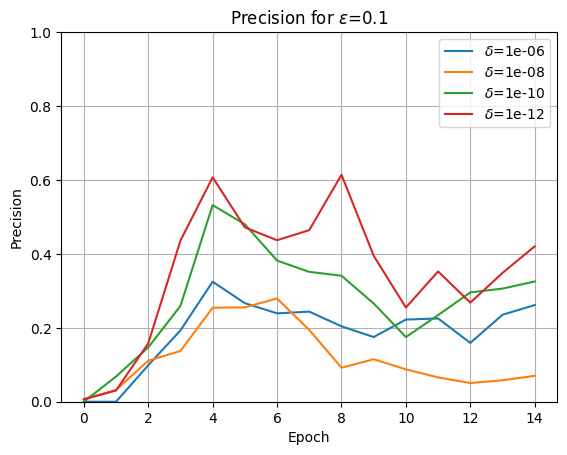

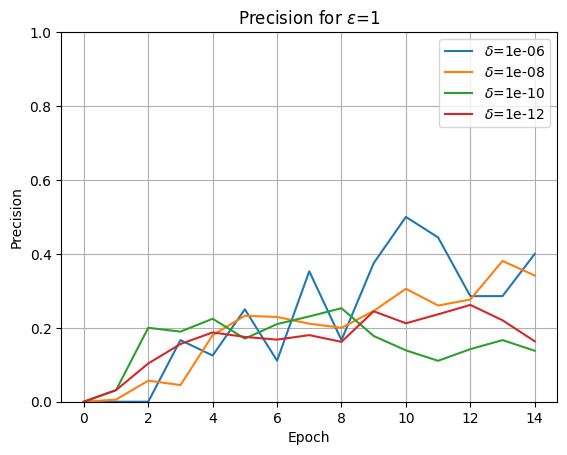

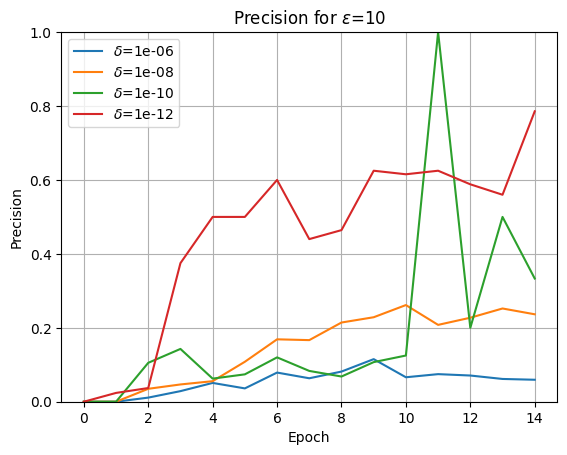

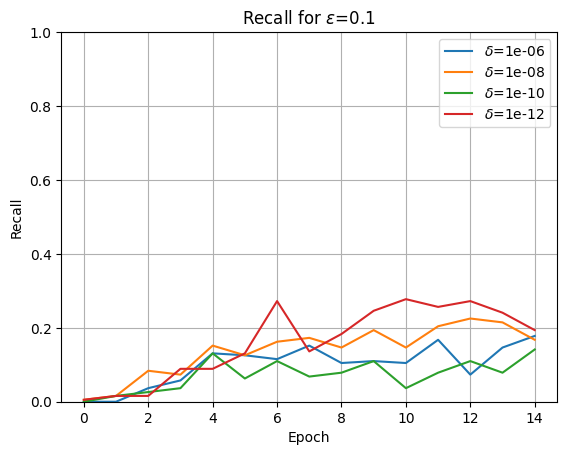

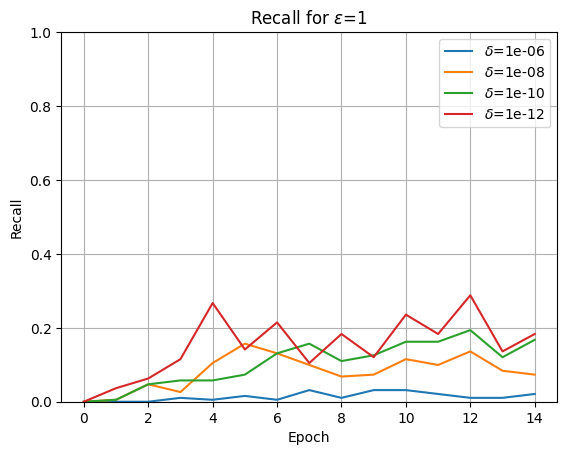

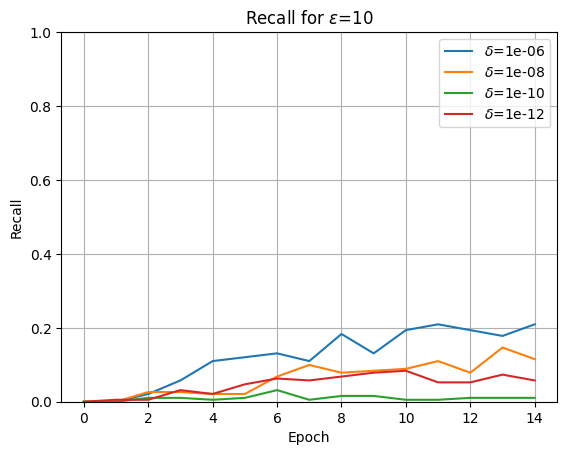

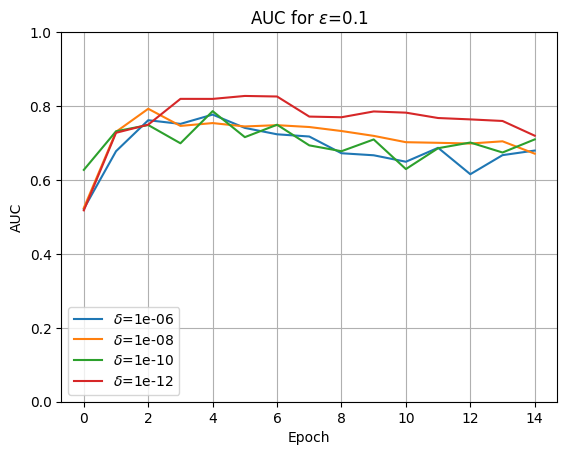

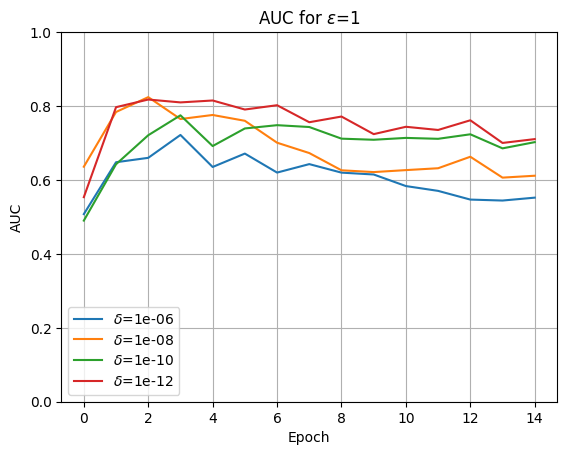

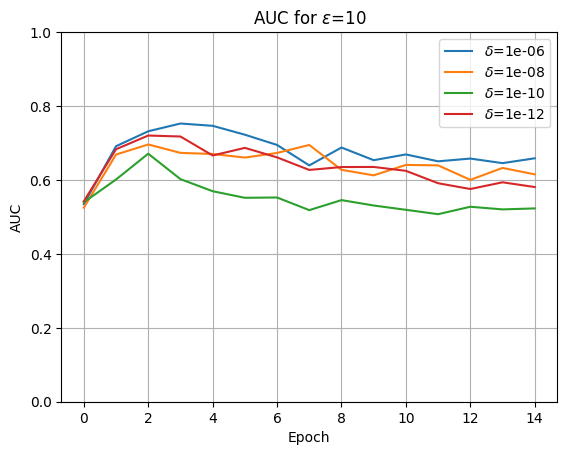

In [36]:
import matplotlib.pyplot as plt


for eps in epsilon_values:
    plt.figure()
    for delta in delta_values: 
        model = models[eps][delta]
        history = hists[eps][delta]
        plt.plot(history.history['val_precision'], label=f'$\delta$={delta}')
    plt.title(f'Precision for $\epsilon$={eps}')
    plt.legend()
    plt.ylim(0, 1)
    plt.grid(True)
    plt.xlabel('Epoch')
    plt.ylabel('Precision')
    plt.show()


for eps in epsilon_values:
    plt.figure()
    for delta in delta_values: 
        model = models[eps][delta]
        history = hists[eps][delta]
        plt.plot(history.history['val_recall'], label=f'$\delta$={delta}')
    plt.title(f'Recall for $\epsilon$={eps}')
    plt.legend()
    plt.ylim(0, 1)
    plt.grid(True)
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.show()

for eps in epsilon_values:
    plt.figure()
    for delta in delta_values: 
        model = models[eps][delta]
        history = hists[eps][delta]
        plt.plot(history.history['val_auc'], label=f'$\delta$={delta}')
    plt.title(f'AUC for $\epsilon$={eps}')
    plt.legend()
    plt.ylim(0, 1)
    plt.grid(True)
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.show()

In [38]:
baseline_attack_results = pickle.load(open('model/varying_dataset_sizes/attacks_results.pkl', 'rb'))

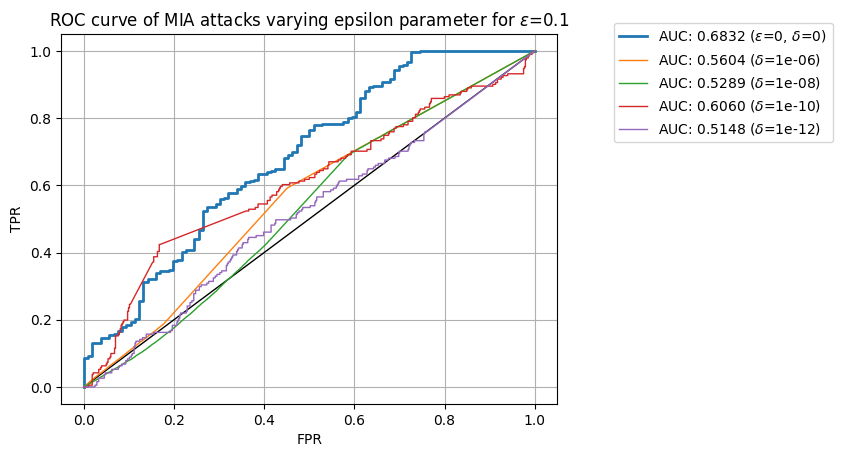

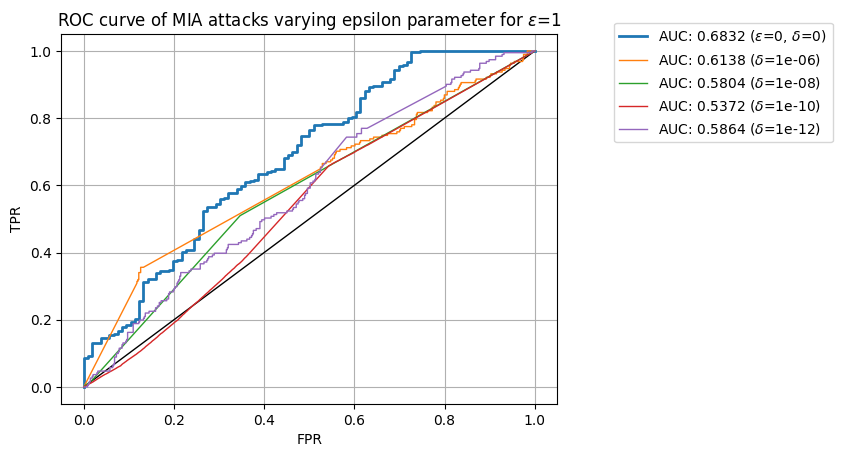

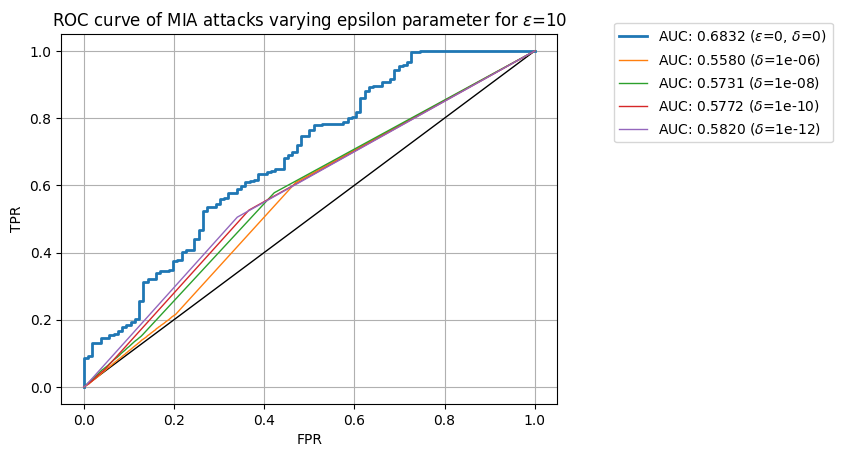

In [40]:
from sklearn import metrics

for eps in attack_results: 
    fig = plt.figure()
    plt.plot([0, 1], [0, 1], 'k', lw=1.0)
    x_baseline = baseline_attack_results[9].roc_curve.fpr
    y_baseline = baseline_attack_results[9].roc_curve.tpr
    auc_baseline = metrics.auc(x_baseline, y_baseline)
    plt.plot(x_baseline, y_baseline, lw=2, label=f'AUC: {auc_baseline:.4f} ($\epsilon$=0, $\delta$=0)')
    for delta in attack_results[eps]:
        if eps == 5:
            continue
        x = attack_results[eps][delta].roc_curve.fpr
        y = attack_results[eps][delta].roc_curve.tpr
        auc = metrics.auc(x, y)
        plt.plot(x, y, lw=1, label=f'AUC: {auc:.4f} ($\delta$={delta})')
    plt.title(f'ROC curve of MIA attacks varying epsilon parameter for $\epsilon$={eps}') 
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.grid(True)
    plt.legend(bbox_to_anchor=(1.1, 1.05))
    plt.show()

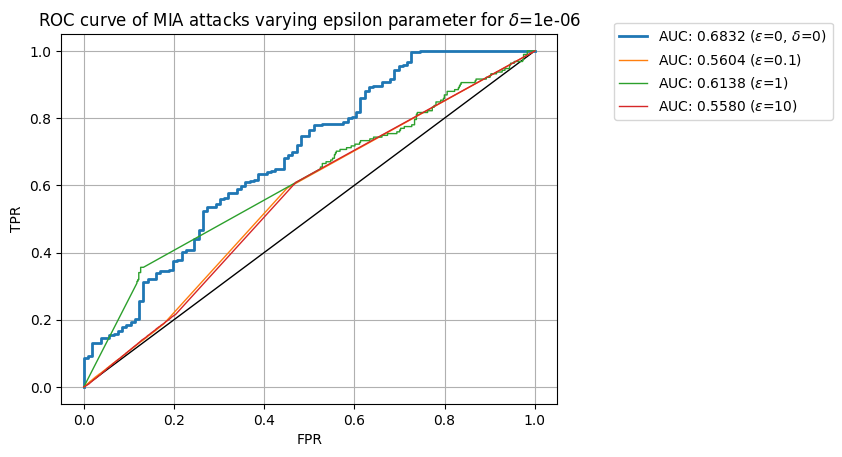

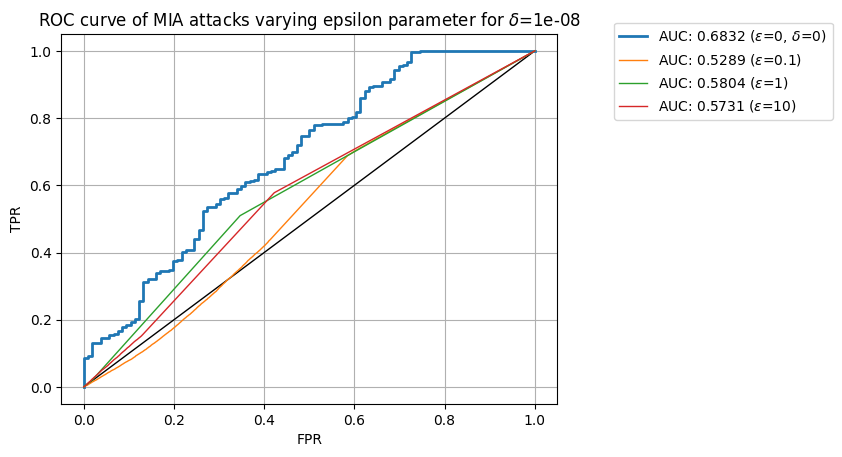

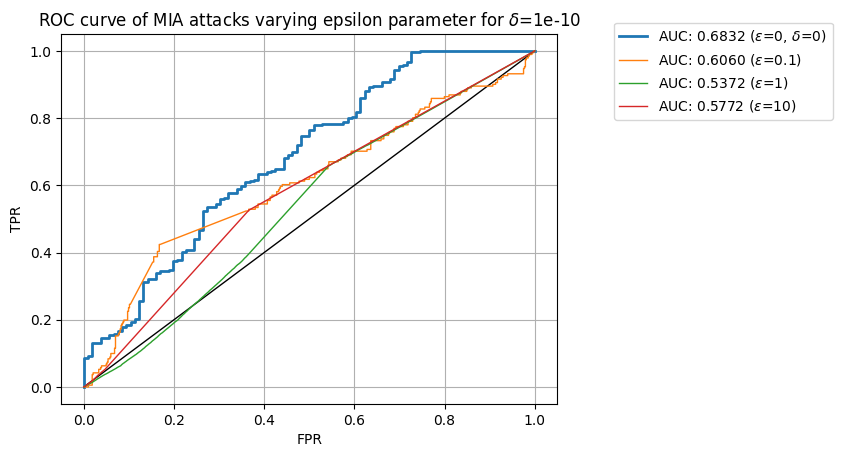

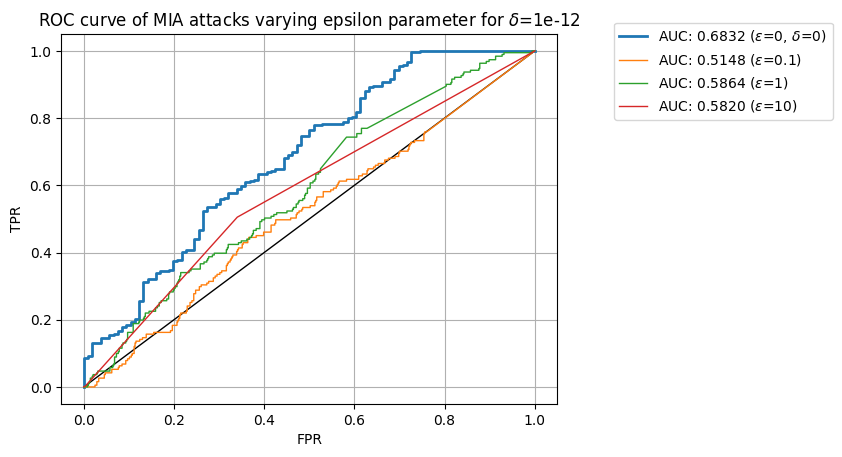

In [41]:
from sklearn import metrics

for delta in attack_results[1]: 
    fig = plt.figure()
    plt.plot([0, 1], [0, 1], 'k', lw=1.0)
    x_baseline = baseline_attack_results[9].roc_curve.fpr
    y_baseline = baseline_attack_results[9].roc_curve.tpr
    auc_baseline = metrics.auc(x_baseline, y_baseline)
    plt.plot(x_baseline, y_baseline, lw=2, label=f'AUC: {auc_baseline:.4f} ($\epsilon$=0, $\delta$=0)')
    for eps in attack_results:
        if eps == 5:
            continue
        x = attack_results[eps][delta].roc_curve.fpr
        y = attack_results[eps][delta].roc_curve.tpr
        auc = metrics.auc(x, y)
        plt.plot(x, y, lw=1, label=f'AUC: {auc:.4f} ($\epsilon$={eps})')
    plt.title(f'ROC curve of MIA attacks varying epsilon parameter for $\delta$={delta}')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.grid(True)
    plt.legend(bbox_to_anchor=(1.1, 1.05))
    plt.show()

In [43]:
from sklearn.metrics import classification_report

classification_reports = {}
for eps in epsilon_values:
    if eps not in classification_reports:
        classification_reports[eps] = {}
    for delta in delta_values:
        model = models[eps][delta]
        
        Xt = X_train_seq_proc_smote[eps][delta]
        yt = y_train_seq_proc_smote[eps][delta]
        Xv = X_val_seq_proc[eps][delta]
        yv = y_val_seq_proc[eps][delta]
        Xte = X_test_seq_proc[eps][delta]
        yte = y_test_seq_proc[eps][delta]
        
        y_pred = model.predict(Xte)
        cr = classification_report(yte, y_pred > 0.5, output_dict=True)
        classification_reports[eps][delta] = cr

2380/2380 [==============================] - 8s 3ms/step


In [47]:
for eps in epsilon_values:
    for delta in delta_values:
        x = attack_results[eps][delta].roc_curve.fpr
        y = attack_results[eps][delta].roc_curve.tpr
        auc = metrics.auc(x, y)
        f1_score = cr['1']['f1-score']
        recall = cr['1']['recall']
        precision = cr['1']['precision']
        print(f"Epsilon: {eps}", end=' ')
        print(f"Delta: {delta}", end=' ')
        print(f"MIA Score: {auc}", end=' ')
        print(f"F1 Score: {f1_score}", end=' ')
        print(f"Precision: {precision}", end=' ')
        print(f"Recall: {recall}")

Epsilon: 0.1 Delta: 1e-06 MIA Score: 0.5604085359878773 F1 Score: 0.09195402298850575 Precision: 0.631578947368421 Recall: 0.049586776859504134
Epsilon: 0.1 Delta: 1e-08 MIA Score: 0.5288891478262469 F1 Score: 0.09195402298850575 Precision: 0.631578947368421 Recall: 0.049586776859504134
Epsilon: 0.1 Delta: 1e-10 MIA Score: 0.6060101250486781 F1 Score: 0.09195402298850575 Precision: 0.631578947368421 Recall: 0.049586776859504134
Epsilon: 0.1 Delta: 1e-12 MIA Score: 0.5147765133486218 F1 Score: 0.09195402298850575 Precision: 0.631578947368421 Recall: 0.049586776859504134
Epsilon: 1 Delta: 1e-06 MIA Score: 0.6138148500713945 F1 Score: 0.09195402298850575 Precision: 0.631578947368421 Recall: 0.049586776859504134
Epsilon: 1 Delta: 1e-08 MIA Score: 0.5803951509003393 F1 Score: 0.09195402298850575 Precision: 0.631578947368421 Recall: 0.049586776859504134
Epsilon: 1 Delta: 1e-10 MIA Score: 0.5372490700103025 F1 Score: 0.09195402298850575 Precision: 0.631578947368421 Recall: 0.04958677685950413